In [1]:
# import libraries
import sys
import statsbombpy
from statsbombpy import sb
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import os, json
import numpy as np
from pitch_official import draw_pitch
import matplotsoccer
import scipy.ndimage
from matplotlib.patches import Arc

# Display options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 3000

# Display options for numpy
np.set_printoptions(linewidth=120, suppress=True)

# Display options for pyplot
%config InlineBackend.figure_format = 'retina'

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import VerticalPitch, Pitch
from mplsoccer.cm import create_transparent_cmap
from mplsoccer.scatterutils import arrowhead_marker

from mplsoccer import VerticalPitch, add_image, FontManager
from mplsoccer.statsbomb import read_event, EVENT_SLUG
import glob

# Declaring credentials
credentials={'user':'vignesh.jayanth@staderennais.fr','passwd':'7XtHANc7'}

In [2]:
all_files=['/Users/vignesh.jayanth/Documents/Trial-Data Exports 2021/France_Ligue_1_2020_2021.ftr']

li = []

for filename in all_files:
    df = pd.read_feather(filename)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [3]:
Positions = {"Central Midfielder": ['Right Center Midfield','Left Center Midfield',
                                    'Center Midfield'],
             "Attacking Midfielder":['Center Attacking Midfield','Right Attacking Midfield', 
                                     'Left Attacking Midfield'],
            "Center Back":['Right Center Back','Left Center Back','Center Back'],
             "Winger":['Left Wing', 'Right Wing','Left Midfield','Right Midfield'],
             "Forward":['Left Center Forward','Center Forward','Right Center Forward'],
             "Right Full Back":['Right Back','Right Wing Back'],
             "Left Full Back":['Left Back','Left Wing Back'],
             "Defensive Midfielder":['Center Defensive Midfield','Left Defensive Midfield','Right Defensive Midfield'],
             'Goalkeeper':['Goalkeeper']}

pos=pd.DataFrame(pd.concat({k: pd.Series(v) for k, v in Positions.items()})).reset_index().set_axis(['position_group', 'NA', 'position'], axis=1, inplace=False)
del pos['NA']


In [4]:
# Check for HNL League
Comps=pd.DataFrame(sb.competitions(fmt="dict",creds=credentials)).T.reset_index(drop=True)
C=pd.DataFrame(sb.matches(competition_id=7, season_id=108, fmt="dict",creds=credentials)).T.reset_index(drop=True)
B=pd.DataFrame(sb.matches(competition_id=7, season_id=90, fmt="dict",creds=credentials)).T.reset_index(drop=True)
A=B.append(C).reset_index(drop=True)

home_team= pd.DataFrame(A['home_team'].tolist(), index= A.index).fillna('').reset_index(drop=True)
away_team= pd.DataFrame(A['away_team'].tolist(), index= A.index).fillna('').reset_index(drop=True)

Match_info=pd.concat([A,home_team,away_team], axis=1)

Match_info=Match_info[['match_id', 'match_date','home_team_name','away_team_name']]

df2=pd.merge(df,Match_info,on='match_id',how='left')


In [ ]:
# 41:20- Sparta Prague vs Olympique Lyonnais - Boetang vs karl tambi

In [5]:
#df2=df.copy()

df2=df2.sort_values(by=['match_id','index'], ascending=[True,True]).reset_index(drop=True)

# Splitting the tactics column #
df2['tactics'] = df2['tactics'].fillna({i: {} for i in df2.index})  # if the column is not strings
df2 = df2.join(json_normalize(df2['tactics']))

# drop tactics
df2.drop(columns=['tactics'], inplace=True)

# Splitting the location column into different Start x, Start y and Start Z columns
df2['location'] = df2['location'].fillna({i: [] for i in df2.index})  # if the column is not strings
df2[['Start_x','Start_y','Start_z']] = pd.DataFrame(df2['location'].tolist(), index= df2.index).fillna(0)

# Splitting the location column into different End x, End y and End Z columns
# Fill rows as nan if they aren't of type dict to keep it coherent

df2['pass_end_location'] = df2['pass_end_location'].fillna({i: [] for i in df2.index})  # if the column is not strings
df2['goalkeeper_end_location'] = df2['goalkeeper_end_location'].fillna({i: [] for i in df2.index})  # if the column is not strings
df2['carry_end_location'] = df2['carry_end_location'].fillna({i: [] for i in df2.index})  # if the column is not strings
df2['shot_end_location'] = df2['shot_end_location'].fillna({i: [] for i in df2.index})  # if the column is not strings

# Split the location rows in a list to dataframe #
df2[['goalkeeper_end_x','goalkeeper_end_y']] = pd.DataFrame(df2['goalkeeper_end_location'].tolist(), index= df2.index).fillna('')
df2[['pass_end_x','pass_end_y']] = pd.DataFrame(df2['pass_end_location'].tolist(), index= df2.index).fillna('')
df2[['carry_end_x','carry_end_y']] = pd.DataFrame(df2['carry_end_location'].tolist(), index= df2.index).fillna('')
df2[['shot_end_x','shot_end_y','End_z']] = pd.DataFrame(df2['shot_end_location'].tolist(), index= df2.index).fillna('')

# Combine the necessary columns into one for uniformity #
df2['End_x'] = df2[['goalkeeper_end_x','pass_end_x',
                           'carry_end_x','shot_end_x']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
df2['End_y'] = df2[['goalkeeper_end_y','pass_end_y',
                           'carry_end_y','shot_end_y']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

# Drop unnecessary columns #
df2=df2.drop(['goalkeeper_end_x','pass_end_x','carry_end_x','shot_end_x','goalkeeper_end_y','pass_end_y',
          'carry_end_y','shot_end_y','location','carry_end_location','goalkeeper_end_location',
          'shot_end_location','pass_end_location'], axis=1)

# Replace Blanks with np.nan's #
df2['End_x']=df2['End_x'].replace('', np.nan).fillna(0)
df2['End_y']=df2['End_y'].replace('', np.nan).fillna(0)
df2['End_x']=df2['End_x'].astype(float)
df2['End_y']=df2['End_y'].astype(float)
df2['End_x']=np.where(df2['End_x']==0,df2['Start_x'],df2['End_x'])
df2['End_y']=np.where(df2['End_y']==0,df2['Start_y'],df2['End_y'])



def convert_dim(df):
    df['Start_x']=df['Start_x']*0.868
    df['End_x']=df['End_x']*0.868
    df['Start_y']=df['Start_y']*0.84
    df['End_y']=df['End_y']*0.84
    
    return df

df3=convert_dim(df2)

#Assigning Proxy associated to x-axis (three Vertical zones)
bins_x = [0,35,71,106]
labels_x = ["Tiers-défensif","Tiers-Médian","Tiers-offensif"]
df3['x_zone_start']= pd.cut(df3['Start_x'], bins=bins_x, labels=labels_x)
df3['x_zone_end']= pd.cut(df3['End_x'], bins=bins_x, labels=labels_x)


#Assigning Proxy associated to the defensive and offensive box
col_1         = 'End_x'
col_2         = 'End_y'
col_3         = 'Start_x'
col_4         = 'Start_y'

conditions  = [(df3[col_1] <= 18) & (df3[col_1] >= 0.1) &(df3[col_2] >= 14.34) & (df3[col_2] <= 53.65),(df3[col_1] >= 88) &(df3[col_1] <= 106)& (df3[col_2] >= 14.34) & (df3[col_2] <= 53.65)]
conditions1  = [(df3[col_3] <= 18) & (df3[col_3] >= 0.1) &(df3[col_4] >= 14.34) & (df3[col_4] <= 53.65),(df3[col_3] >= 88) &(df3[col_3] <= 106)& (df3[col_4] >= 14.34) & (df3[col_4] <= 53.65)]
choices     = [ "Defensive-surface", 'Offensif-surface']
    
df3["into_box"] = np.select(conditions, choices, default='Open-Play')
df3["from_box"] = np.select(conditions1, choices, default='Open-Play')

#Assigning Proxy associated to y-axis (5 horizontal corridors)
bins_y = [0,14,25,43,54,68]
labels_y = ["Gauche","Demi-espace Gauche","Centre","Demi-espace Droit","Droit"]
df3['y_zone_start']= pd.cut(df3['Start_y'], bins=bins_y, labels=labels_y)
df3['y_zone_end']= pd.cut(df3['End_y'], bins=bins_y, labels=labels_y)


# Renaming 50°50 Columns for relevant outcomes
df3=df3.rename(columns={'outcome.id': '50_50_outcome_id', 'outcome.name': '50_50_outcome_name'})

# Add distance between consecutive actions

def add_distance_to_ball(df3):

    df3['distance'] = df3[['Start_x', 'Start_y']].sub(np.array(df3[['End_x', 'End_y']] )).pow(2).sum(1).pow(0.5)
    df3.distance = df3.distance.round(2)
    return(df3)

def add_rolling_time_ball(df3):

    df3=df3.sort_values(['match_id','minute','second'], ascending=[True,True,True])
    df3['Time_sec']=(df3['minute']*60)+df3['second']
    df3['Time_taken_for_event'] = df3['Time_sec'] - df3['Time_sec'].shift(+1)
    df3['Time_taken_for_event']=df3['Time_taken_for_event'].fillna(0)
    df3['Time_taken_for_event']=np.where(df3['Time_taken_for_event']>4,2,df3['Time_taken_for_event'])
    
    return(df3)

df3=add_rolling_time_ball(df3)
df3=add_distance_to_ball(df3)


df3['clearance_body_part']=df3['clearance_body_part'].fillna('')
df3['goalkeeper_body_part']=df3['goalkeeper_body_part'].fillna('')
df3['pass_body_part']=df3['pass_body_part'].fillna('')
df3['shot_body_part']=df3['shot_body_part'].fillna('')

# Combine the necessary columns into one for uniformity #
df3['body_part'] = df3[['clearance_body_part', 'goalkeeper_body_part', 'pass_body_part','shot_body_part']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
df3['body_part']=df3['body_part'].str.replace('None','')
df3['technique'] = df3[['goalkeeper_technique', 'pass_technique', 'shot_technique']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
df3['technique']=df3['technique'].str.replace('None','')

df3['xy_zone_start'] = df3[['x_zone_start', 'y_zone_start']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df3['xy_zone_start'] = np.where(df3['from_box']!='Open-Play',df3['from_box'],df3['xy_zone_start'])

df3['xy_zone_end'] = df3[['x_zone_end', 'y_zone_end']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df3['xy_zone_end'] = np.where(df3['into_box']!='Open-Play',df3['into_box'],df3['xy_zone_end'])

df3=pd.merge(df3,pos,on='position',how='left')




<ipython-input-5-8dcbed4ffffa>:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df2 = df2.join(json_normalize(df2['tactics']))


In [7]:
# Attacking Action 1 #

def pass_actions(df3,Main_Action):
    
    keep_variables=['Time_taken_for_event','position_group','player','team','position','id','away_team_name',
                    'Start_x','Start_y','End_x', 'End_y','xy_zone_start','xy_zone_end','possession']

    pass_cols = list(df3.filter(regex='pass').columns)

    pass_list = pass_cols + keep_variables

    keep_df=df3[df3['type']==Main_Action][pass_list].reset_index(drop=True)

    # Get list of all columns that need converting from binary columns #

    other_pass_outcomes=['Unknown', 'Pass Offside', 'Injury Clearance']
    
    keep_df['pass_outcome']=np.where(keep_df['pass_outcome'].isin(other_pass_outcomes),'Other',keep_df['pass_outcome'])
    keep_df['pass_outcome']=keep_df['pass_outcome'].replace(np.nan,'Complete')
    keep_df['pass_technique']=keep_df['pass_technique'].replace(np.nan,'Other')
    keep_df['pass_type']=keep_df['pass_type'].replace('None','Other')
    keep_df['pass_body_part']=keep_df['pass_body_part'].replace('','Other')
    
    set_pieces=['Free Kick', 'Goal Kick', 'Throw-in','Corner']
    keep_df=keep_df[~keep_df['pass_type'].isin(set_pieces)].reset_index(drop=True)

    
    binary_cols = list(keep_df.columns[keep_df.isin([None,True]).all()])

    bool_dict= {
       True: 1,
       None: 0
    }

    for column in binary_cols:
        keep_df[column] = keep_df[column].map(bool_dict)
    
    return keep_df


In [8]:
pass_df=pass_actions(df3,'Pass')


In [56]:
# Attacking Strategies - 5 actions before getting a shot or ball entering box



time: 198 µs (started: 2022-01-09 15:48:35 +01:00)


In [17]:
check = df2.filter(regex='xg')
print(check.columns)

Index(['shot_statsbomb_xg'], dtype='object')


In [25]:
# Check Number of Actions #

surfaces=['Offensif-surface','Tiers-offensif Droit','Tiers-offensif Demi-espace Gauche', 
          'Tiers-offensif Gauche', 'Tiers-offensif Centre','Offensif-surface', 
          'Tiers-offensif Demi-espace Droit']

pass_df=pass_actions(df3,'Pass')
pass_check=pass_df[(pass_df['xy_zone_end'].isin(surfaces))|(pass_df['xy_zone_start'].isin(surfaces))].reset_index(drop=True)
                                                        
# Passes ending up in a shot from various locations in the final third- Team, Pass complete %, type of passes and location of passes
pass_check_df=pass_check[~pass_check['pass_assisted_shot_id'].isnull()].reset_index(drop=True)

shot_assists=list(pass_check_df.pass_assisted_shot_id.unique())

shot_assists_df=df3[df3['id'].isin(shot_assists)][['type','player','possession','Start_x','match_id',
                                                   'Start_y','End_x','End_y','position','id',
                                                   'shot_statsbomb_xg']].reset_index(drop=True)

shot_ids=list(shot_assists_df.id.unique())

possession_ids=list(shot_assists_df.possession.unique())


In [26]:
shot_assists_df

type                       player  possession  Start_x match_id  \
0     Shot         Glody Ngonda Muzinga           8  80.2900  3755852   
1     Shot           Aka Wilfried Kanga          23  89.5776  3755852   
2     Shot                  Sada Thioub          28  89.1436  3755852   
3     Shot      Eric Junior Dina Ebimbe          44  91.4872  3755852   
4     Shot                  Sada Thioub          48  85.0640  3755852   
...    ...                          ...         ...      ...      ...   
4926  Shot                Romain Faivre         137  95.9140  3770761   
4927  Shot  Mauro Emanuel Icardi Rivero         143  93.6572  3770761   
4928  Shot         Kylian Mbappé Lottin         145  95.0460  3770761   
4929  Shot         Kylian Mbappé Lottin         154  96.9556  3770761   
4930  Shot                Irvin Cardona         157  91.1400  3770761   

      Start_y     End_x   End_y             position  \
0      20.328  102.1636  33.432            Left Back   
1      47.628   95.3064  41.748       Center Forward   
2      41.076   89.6644  40.740       Right Midfield   
3      23.352   92.2684  24.108           Right Wing   
4      29.064   96.0876  28.308       Right Midfield   
...       ...       ...     ...                  ...   
4926   34.356  103.2920  33.516       Right Midfield   
4927   29.904   96.1744  30.324           Right Wing   
4928   42.840  102.6844  36.204       Center Forward   
4929   37.128  104.1600  29.736       Center Forward   
4930   22.428  102.5108  30.408  Left Center Forward   

                                        id  shot_statsbomb_xg  
0     bea7aa77-e9b0-4f8f-a251-b5f0582d5f43           0.009364  
1     2251791e-8748-4cbf-9a7b-cc9995c3f438           0.264065  
2     d311f9fe-cd3c-43e3-9396-cb186af308ed           0.040605  
3     8b677c34-764f-42cf-aae1-c02fec765549           0.127706  
4     3af7133a-19a9-4eb1-9ff4-536900d0e930           0.042899  
...                                    ...                ...  
4926  cf398153-4a78-4582-9531-f385dbdbe42a           0.314047  
4927  a088080b-659e-4cf5-82b5-8f706d44c8bc           0.262984  
4928  062b99a0-3550-40cc-bc54-92fc28c04a23           0.186651  
4929  9ac56635-4418-4f8f-b9aa-56f42d186b00           0.311215  
4930  4764c129-61fc-478c-9ec3-4051fd84b7e2           0.065134  

[4931 rows x 11 columns]

In [21]:
df4=df3.copy()

In [24]:
# Select possession chains where the shot ids

df4['possession_chain']=df4.groupby((df4['possession'] != df4['possession'].shift(1)).cumsum()).cumcount()+1
possession_chain


AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

In [ ]:
shot_xg=df4[df4['shot_count']==1][['possession','shot_statsbomb_xg','team','id',
                                                         'match_id','type']]


In [44]:
shot_xg

Empty DataFrame
Columns: [possession, shot_statsbomb_xg, team, id, match_id, type]
Index: []

Text(0.5, 1.0, 'End Locations of Assists through-Crosses')

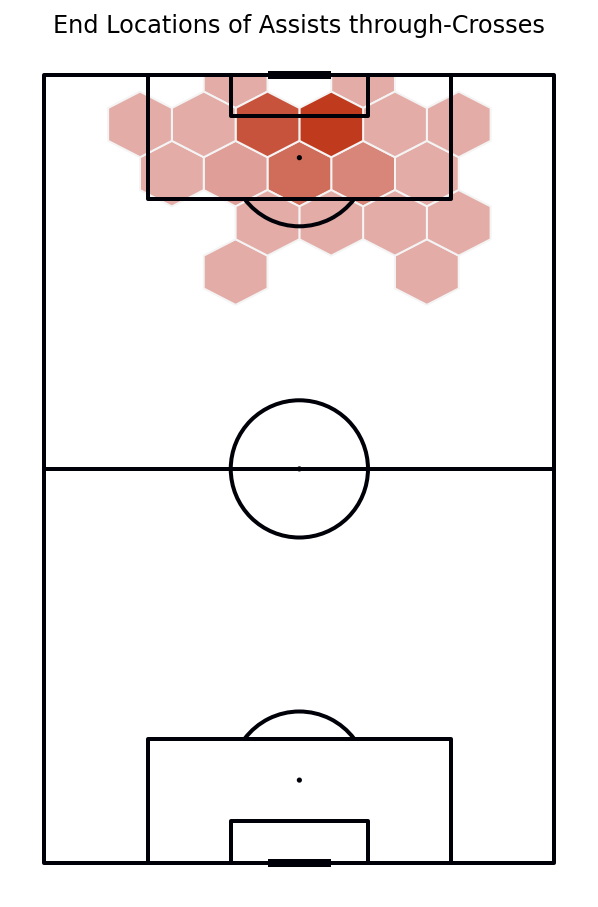

In [16]:
# Get all the the ids as one #
flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 10 colors",
                                                  ['#e3aca7', '#c03a1d'], N=10)

pitch = VerticalPitch(pitch_type='uefa',line_color='#000009', line_zorder=2, pitch_color='white')
fig, ax = pitch.draw(figsize=(4.4, 6.4))
hexmap = pitch.hexbin(TB.End_x, TB.End_y, ax=ax, edgecolors='#f4f4f4',
                      gridsize=(8, 8), cmap=flamingo_cmap)

plt.title("End Locations of Assists through-Crosses", color='black')

Text(0.5, 0.9, 'End Locations of Passes into Box/Final Third')

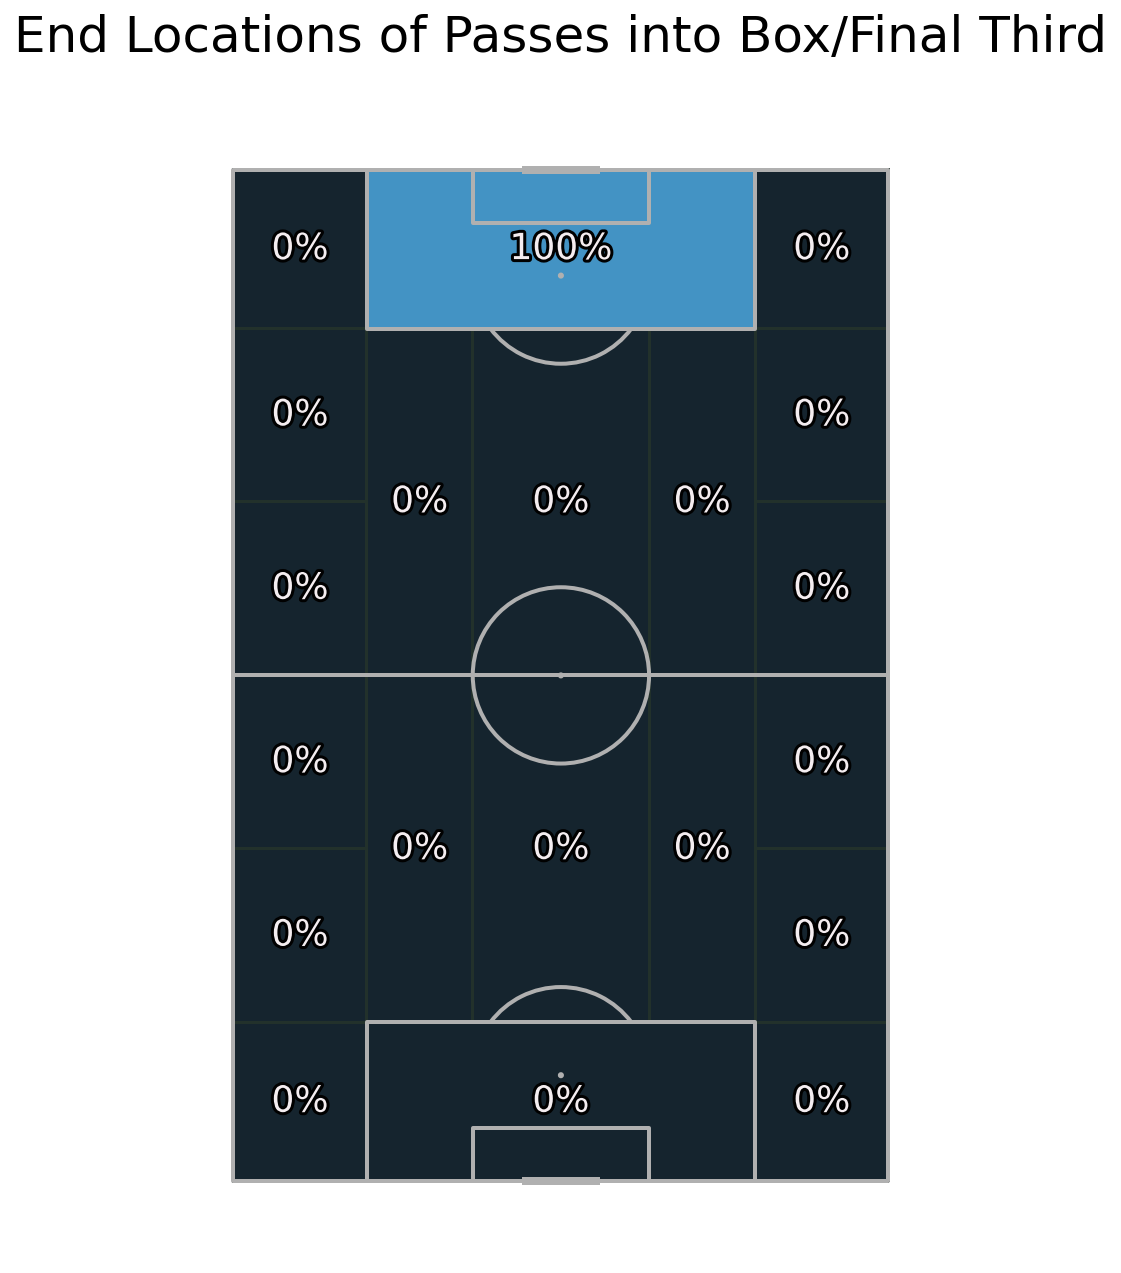

In [28]:
# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)

# fontmanager for google font (robotto)
robotto_regular = FontManager()

path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]

TB=pass_df[(pass_df['pass_cross']==1) & (pass_df['pass_cut_back']==1)]

TB=TB[TB['pass_goal_assist']==True].reset_index(drop=True)

pitch = VerticalPitch(pitch_type='uefa', line_zorder=2, pitch_color='w')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('w')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(TB.End_x, TB.End_y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap=pearl_earring_cmap, edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# endnote and title
axs['title'].text(0.5, 0.9, "End Locations of Passes into Box/Final Third", color='black',
                  va='center', ha='center', fontsize=25)
# sphinx_gallery_thumbnail_path = 'gallery/pitch_plots/images/sphx_glr_plot_heatmap_positional_002.png'


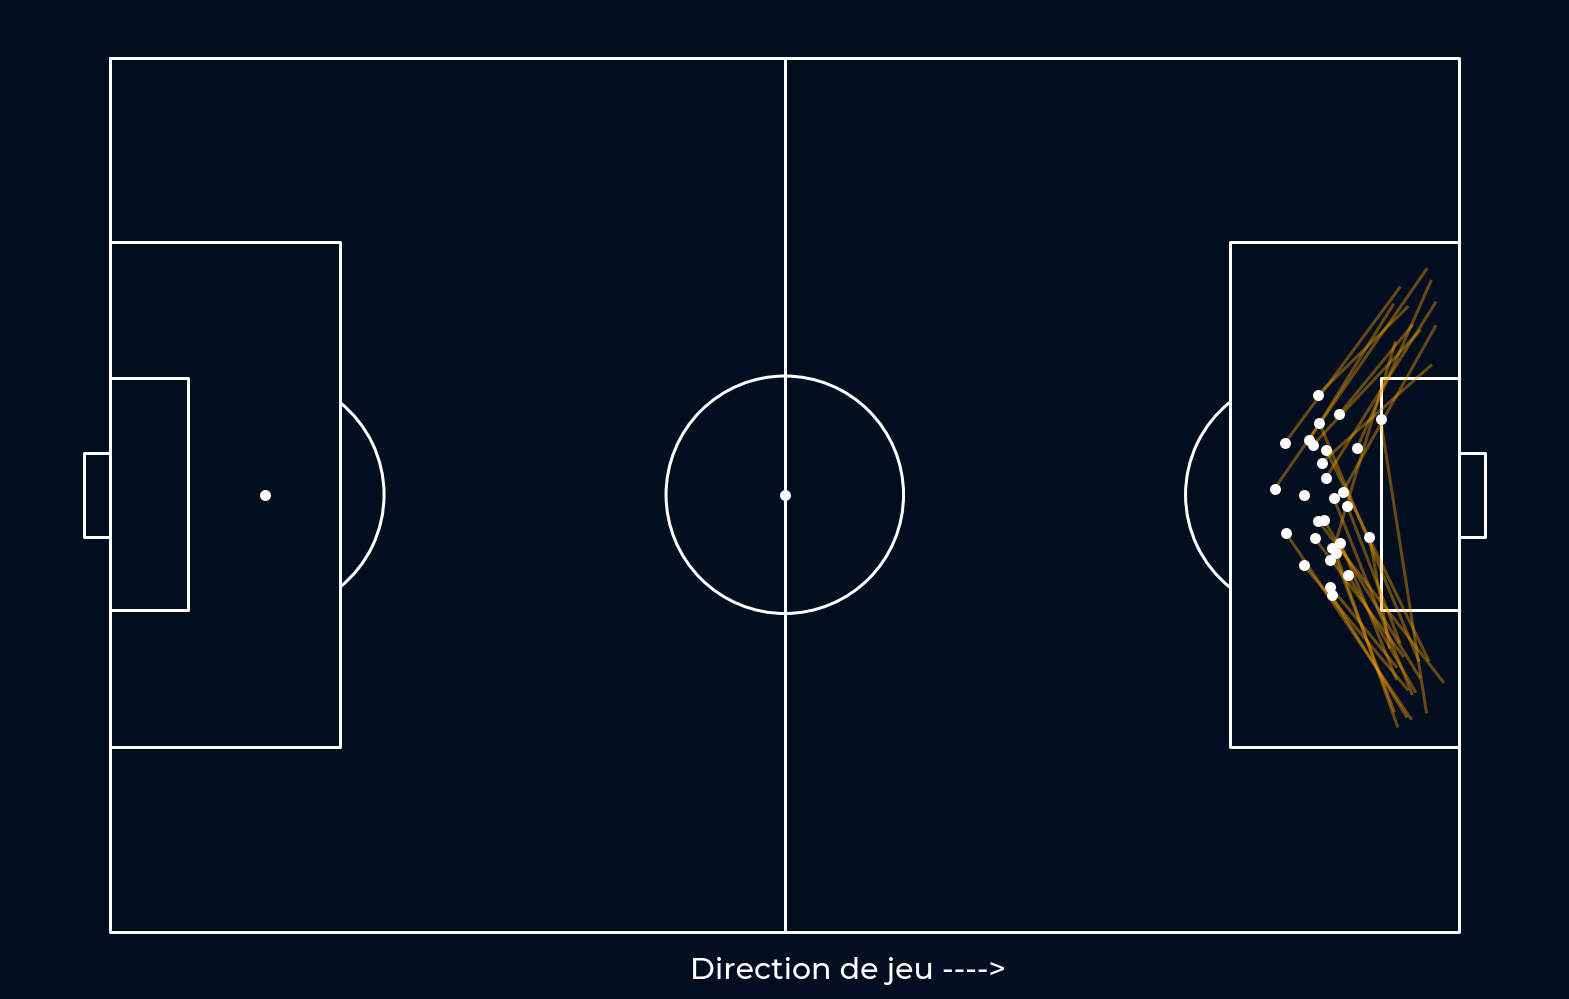

In [29]:
csfont = {'fontfamily':'Montserrat'}


# Where are his passes coming from when played into the final third or the box?

Team='Rennes'
Player='Serhou Guirassy'
Technique='Through Ball'
Pattern='Regular Play'


# Visualize through balls from Lovro Majer #  
background = "#030E21"

# For Horizontal View #
fig, ax = plt.subplots(figsize=(11, 7))

fig.set_facecolor(background)

draw_pitch(orientation="h",
           aspect="full",
           pitch_color=background, 
           line_color="w",
           ax=ax)

x = TB.Start_x.values
y = TB.Start_y.values
xe = TB.End_x.values
ye = TB.End_y.values
ph = TB.pass_height.values


def hanging_line(point1, point2):
    import numpy as np

    a = (point2[1] - point1[1])/(np.cosh(point2[0]) - np.cosh(point1[0]))
    b = point1[1] - a*np.cosh(point1[0])
    x = np.linspace(point1[0], point2[0], 100)
    y = a*np.cosh(x) + b

    return (x,y)


point1 = [x,y]
point2 = [xe,ye]
x1,y1=hanging_line(point1, point2)

plt.scatter(xe,ye,color="w",edgecolors="w",zorder=20,alpha=1,s=20)

    
plt.plot([x,xe],[y,ye],alpha=0.4,color="orange")


#plt.title("Through Passes Made in Open Play sequences",fontsize=18,color="w",**csfont,fontweight="bold")
fig.text(0.44,0.02,'Direction de jeu ---->',fontweight="bold", fontsize=15,**csfont, color="w") ###change



plt.tight_layout()
plt.show()

In [78]:
def hanging_line(point1, point2):
    import numpy as np

    a = (point2[1] - point1[1])/(np.cosh(point2[0]) - np.cosh(point1[0]))
    b = point1[1] - a*np.cosh(point1[0])
    x = np.linspace(point1[0], point2[0], 100)
    y = a*np.cosh(x) + b

    return (x,y)

time: 535 µs (started: 2022-01-09 16:08:04 +01:00)


findfont: Font family ['Montserrat'] not found. Falling back to DejaVu Sans.


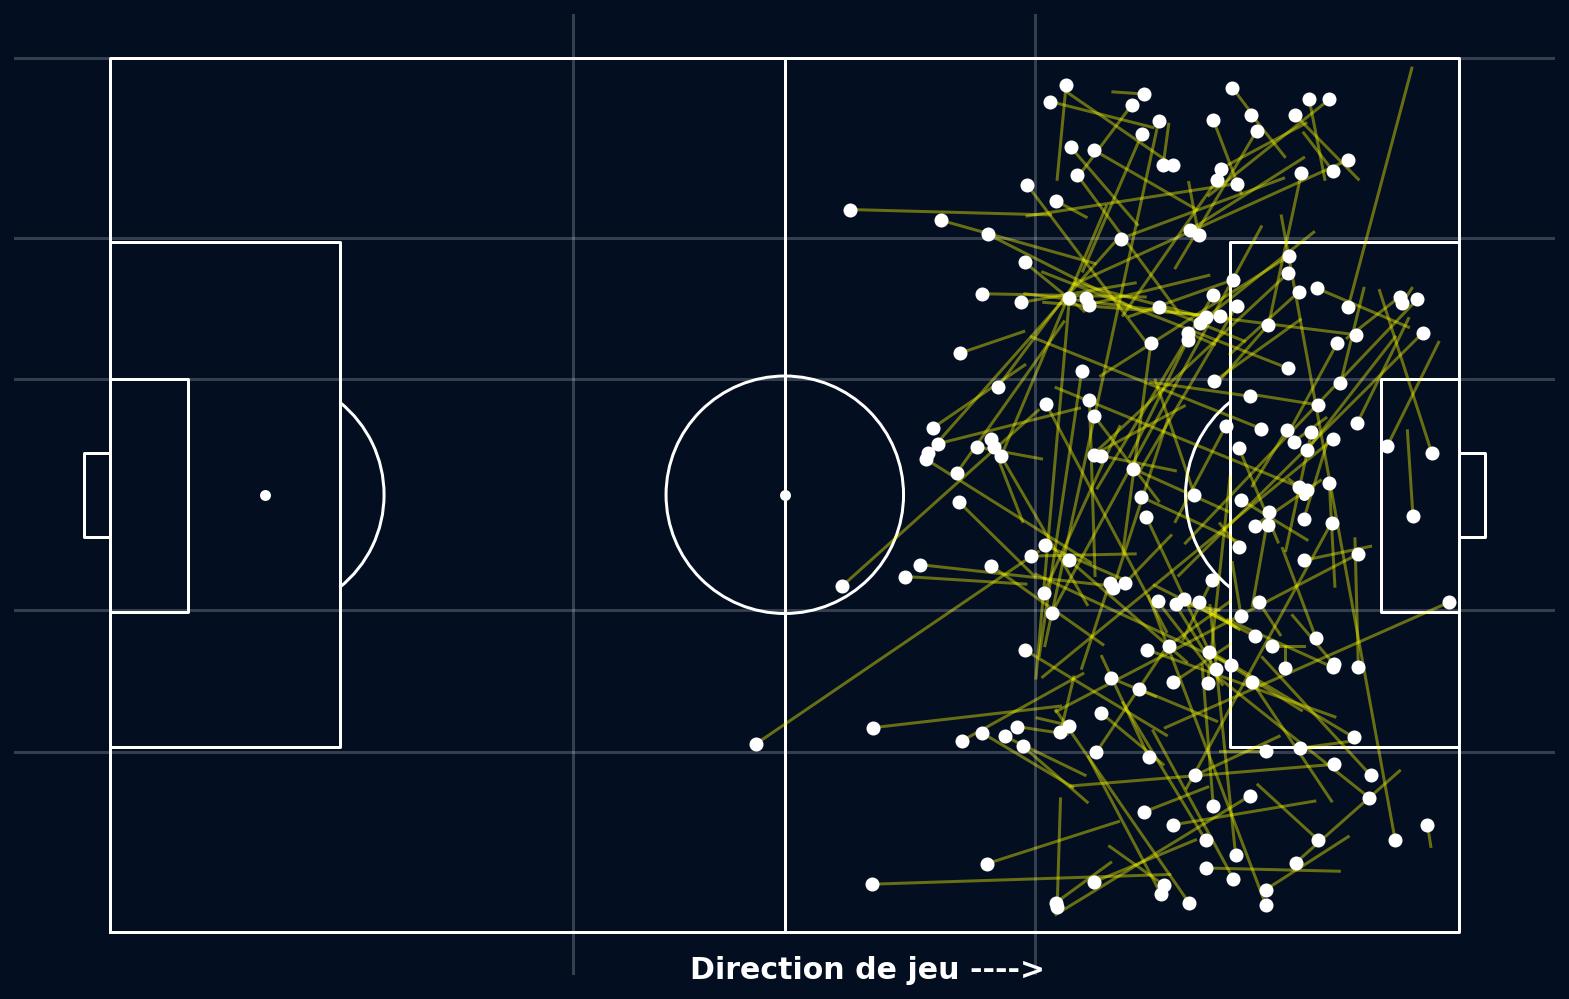

time: 1.02 s (started: 2021-09-15 17:28:46 +02:00)


In [10]:
csfont = {'fontfamily':'Montserrat'}


# Where are his passes coming from when played into the final third or the box?

Team='Rennes'
Player='Serhou Guirassy'
Technique='Through Ball'
Pattern='Regular Play'

TB=df3[(df3['type']=='Pass') &
     (df3['player']==Player) &
      (df3['x_zone']=='Tiers-offensif')].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)


# Visualize through balls from Lovro Majer #  
background = "#030E21"

# For Horizontal View #
fig, ax = plt.subplots(figsize=(11, 7))

fig.set_facecolor(background)

draw_pitch(orientation="h",
           aspect="full",
           pitch_color=background, 
           line_color="w",
           ax=ax)

x = TB.Start_x.values
y = TB.Start_y.values
xe = TB.End_x.values
ye = TB.End_y.values

plt.scatter(xe,ye,color="w",edgecolors="w",zorder=20,alpha=1)

plt.plot([x,xe],[y,ye],alpha=0.4,color="yellow")

#plt.title("Through Passes Made in Open Play sequences",fontsize=18,color="w",**csfont,fontweight="bold")
fig.text(0.44,0.02,'Direction de jeu ---->',fontweight="bold", fontsize=15,**csfont, color="w") ###change


plt.axhline(y=14,color="w",alpha=0.2)
plt.axhline(y=25,color="w",alpha=0.2)
plt.axhline(y=43,color="w",alpha=0.2)
plt.axhline(y=54,color="w",alpha=0.2)
plt.axhline(y=68,color="w",alpha=0.2)
plt.axvline(x=36,color="w",alpha=0.2)
plt.axvline(x=72,color="w",alpha=0.2)


plt.tight_layout()
plt.show()

Text(0.5, 0.5, 'Dribbles/Carries made from Open Play')

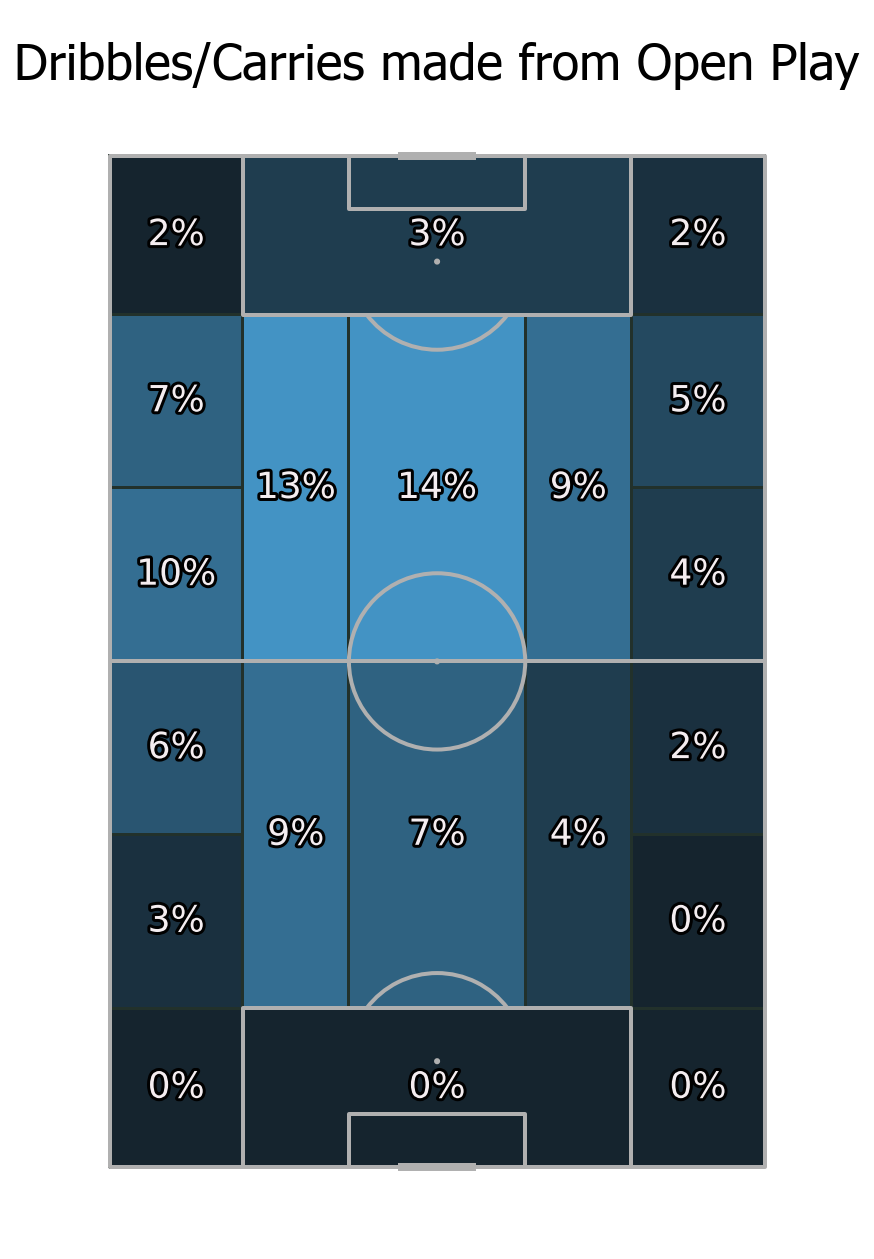

time: 3.02 s (started: 2021-09-06 09:02:24 +02:00)


In [8]:
#GoalKicks1,Corner1,FreeKicks1,Counter_Attack1,Regular_Play1

# Where are his Ball Receptions coming from Goal Kicks?

Team='Dinamo Zagreb'
Player='Lovro Majer'
Technique='Through Ball'
Pattern=['From Free Kick','From Corner']
season_name='2020/2021'

Actions=['Carry','Dribble']

# Identify starting locations of player passes in the mid and offensive tiers #

TB=df3[(df3['type'].isin(Actions)) & (df3['player']==Player)].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)


# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)

# fontmanager for google font (robotto)
robotto_regular = FontManager()

path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]



pitch = VerticalPitch(pitch_type='uefa', line_zorder=2, pitch_color='w')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('w')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(TB.Start_x, TB.Start_y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap=pearl_earring_cmap, edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# endnote and title
axs['title'].text(0.5, 0.5, "Dribbles/Carries made from Open Play", color='black',
                  va='center', ha='center',font='tahoma', fontsize=25)
# sphinx_gallery_thumbnail_path = 'gallery/pitch_plots/images/sphx_glr_plot_heatmap_positional_002.png'


In [12]:
df3['season_name1']=df3['season_name'].str[2:4]
df3['season_name2']=df3['season_name'].str[::2]

df3.season_name1.unique()

array(['20'], dtype=object)

time: 477 ms (started: 2021-09-06 09:15:11 +02:00)


In [13]:
#Rightnow

array(['2020/2021', '2019/2020'], dtype=object)

time: 61.8 ms (started: 2021-09-06 09:16:01 +02:00)


In [28]:
TB_df.season_name.unique()

array(['2019/2020', '2020/2021'], dtype=object)

time: 2.3 ms (started: 2021-09-06 09:57:48 +02:00)


In [35]:
TB_df=pd.DataFrame(TB.groupby(['season_name','type','x_zone', 'y_zone']).size() / len(TB)*100)
TB_df=TB_df.set_axis(['Percentage'], axis=1, inplace=False)
TB_df.reset_index(level=['season_name','type','x_zone', 'y_zone'],inplace=True)
TB_df.to_excel('/Users/vignesh.jayanth/Documents/Lovro Majer/TB_Composition.xlsx')

time: 142 ms (started: 2021-09-06 10:24:14 +02:00)


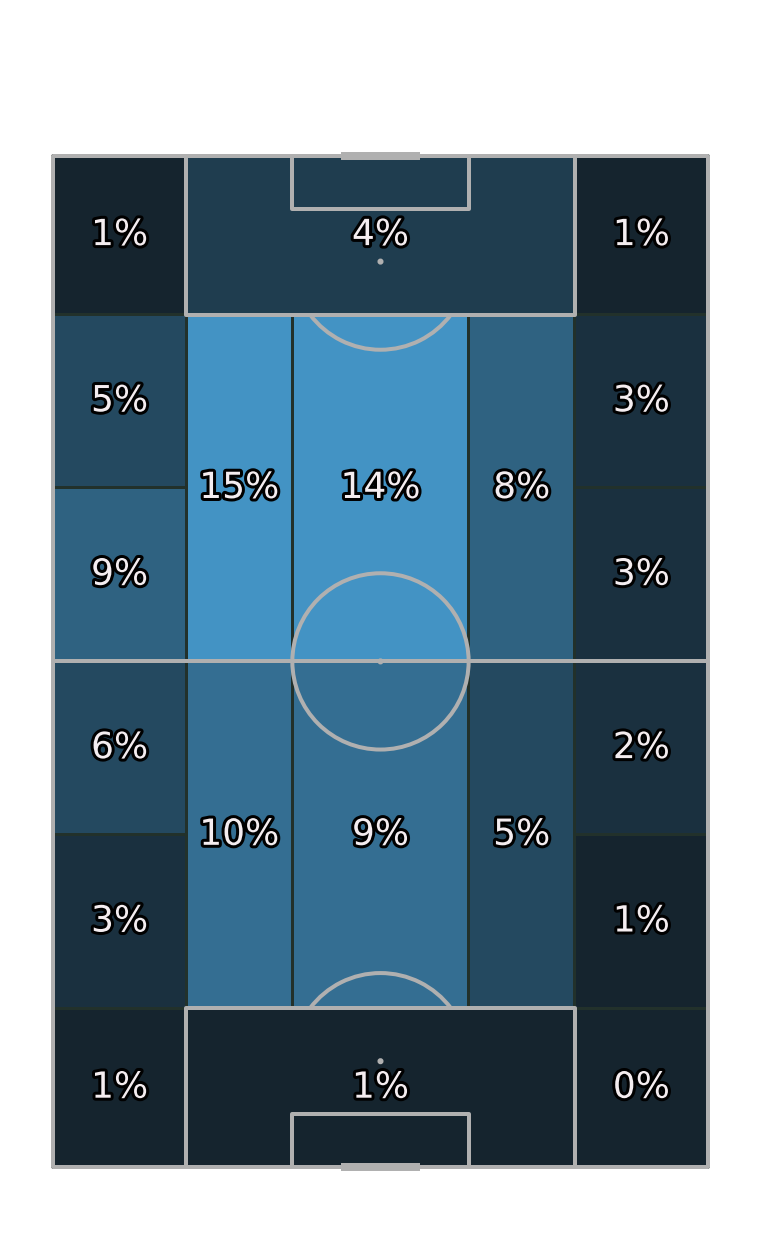

time: 850 ms (started: 2021-09-06 10:05:30 +02:00)


In [31]:
# Where are his Passes coming from Goal Kicks?

Team='Dinamo Zagreb'
Player='Lovro Majer'
Technique='Through Ball'
Pattern='Regular Play'
season_name='2020/2021'

Actions_involved=['Carry','Pass','Dribble','Ball Receipt*']

# Identify starting locations of player passes in the mid and offensive tiers #

TB=Regular_Play1[(Regular_Play1['type'].isin(Actions_involved)) & (Regular_Play1['player']==Player)].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)

#GoalKicks1,Corner1,FreeKicks1,Counter_Attack1,Regular_Play1

# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)

# fontmanager for google font (robotto)
robotto_regular = FontManager()

path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]



pitch = VerticalPitch(pitch_type='uefa', line_zorder=2, pitch_color='w')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('w')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(TB.Start_x, TB.Start_y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap=pearl_earring_cmap, edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# sphinx_gallery_thumbnail_path = 'gallery/pitch_plots/images/sphx_glr_plot_heatmap_positional_002.png'


In [15]:
# Where are his Passes coming from Goal Kicks?

Team='Dinamo Zagreb'
Player='Lovro Majer'
Technique='Through Ball'
Pattern='Regular Play'
season_name='2019/2020'

# Identify starting locations of player passes in the mid and offensive tiers #

TB=df3[(df3['type']=='Pass') & (df3['player']==Player) & (df3['next_x_zone1'].isin(Tiers)) & 
       (df3['next_x_zone2'].isin(Tiers))].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)


# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)

# fontmanager for google font (robotto)
robotto_regular = FontManager()

path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]



pitch = VerticalPitch(pitch_type='uefa', line_zorder=2, pitch_color='w')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('w')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(TB.Start_x, TB.Start_y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap=pearl_earring_cmap, edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# endnote and title
axs['title'].text(0.5, 0.9, "Passes into Final Third", color='black',
                  va='center', ha='center',font='tahoma', fontsize=25)
# sphinx_gallery_thumbnail_path = 'gallery/pitch_plots/images/sphx_glr_plot_heatmap_positional_002.png'


NameError: name 'Tiers' is not defined

time: 1.35 s (started: 2021-09-06 09:20:46 +02:00)


Text(0.5, 0.9, 'Passes from Goal Kicks (20/2&)')

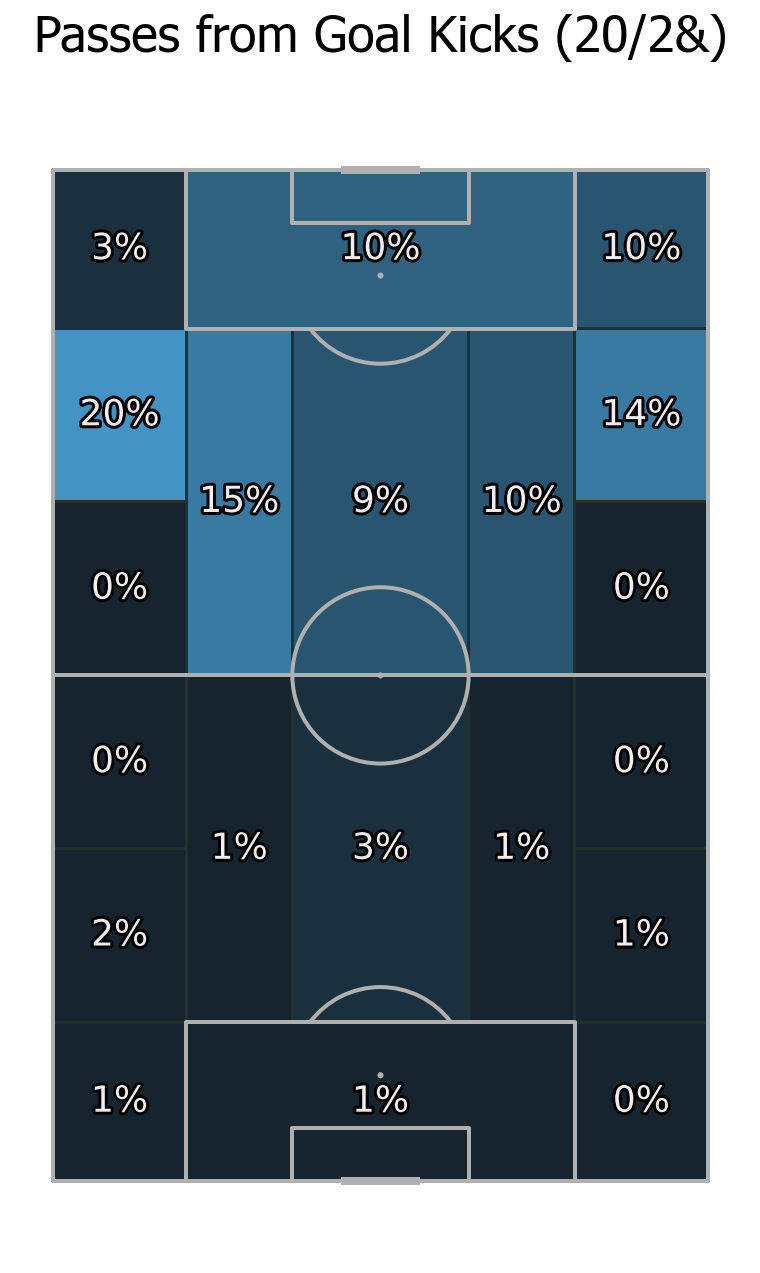

time: 1.06 s (started: 2021-09-01 17:27:24 +02:00)


In [52]:
# Where are his Passes coming from Goal Kicks?

Team='Dinamo Zagreb'
Player='Lovro Majer'
Technique='Through Ball'
Pattern='Regular Play'
season_name='2020/2021'

# Identify starting locations of player passes in the mid and offensive tiers #

TB=df3[(df3['type']=='Pass') & (df3['player']==Player) & (df3['next_x_zone1'].isin(Tiers)) &
       (df3['season_name']==season_name)].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)


# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)

# fontmanager for google font (robotto)
robotto_regular = FontManager()

path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]



pitch = VerticalPitch(pitch_type='uefa', line_zorder=2, pitch_color='w')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('w')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(TB.Start_x, TB.Start_y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap=pearl_earring_cmap, edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)

# endnote and title
axs['title'].text(0.5, 0.9, "Passes from Goal Kicks (20/2&)", color='black',
                  va='center', ha='center',font='tahoma', fontsize=25)
# sphinx_gallery_thumbnail_path = 'gallery/pitch_plots/images/sphx_glr_plot_heatmap_positional_002.png'


In [35]:
x

array([], dtype=float64)

time: 8.18 ms (started: 2021-08-27 11:08:19 +02:00)


In [151]:
TB_df=pd.DataFrame(TB.groupby(['x_zone', 'y_zone']).size() / len(TB)*100)
TB_df=TB_df.set_axis(['Percentage'], axis=1, inplace=False)
TB_df.reset_index(level=['x_zone', 'y_zone'],inplace=True)
TB_df.to_excel('/Users/vignesh.jayanth/Documents/Lovro Majer/TB_Composition2.xlsx')

time: 24.8 ms (started: 2021-08-26 17:37:30 +02:00)


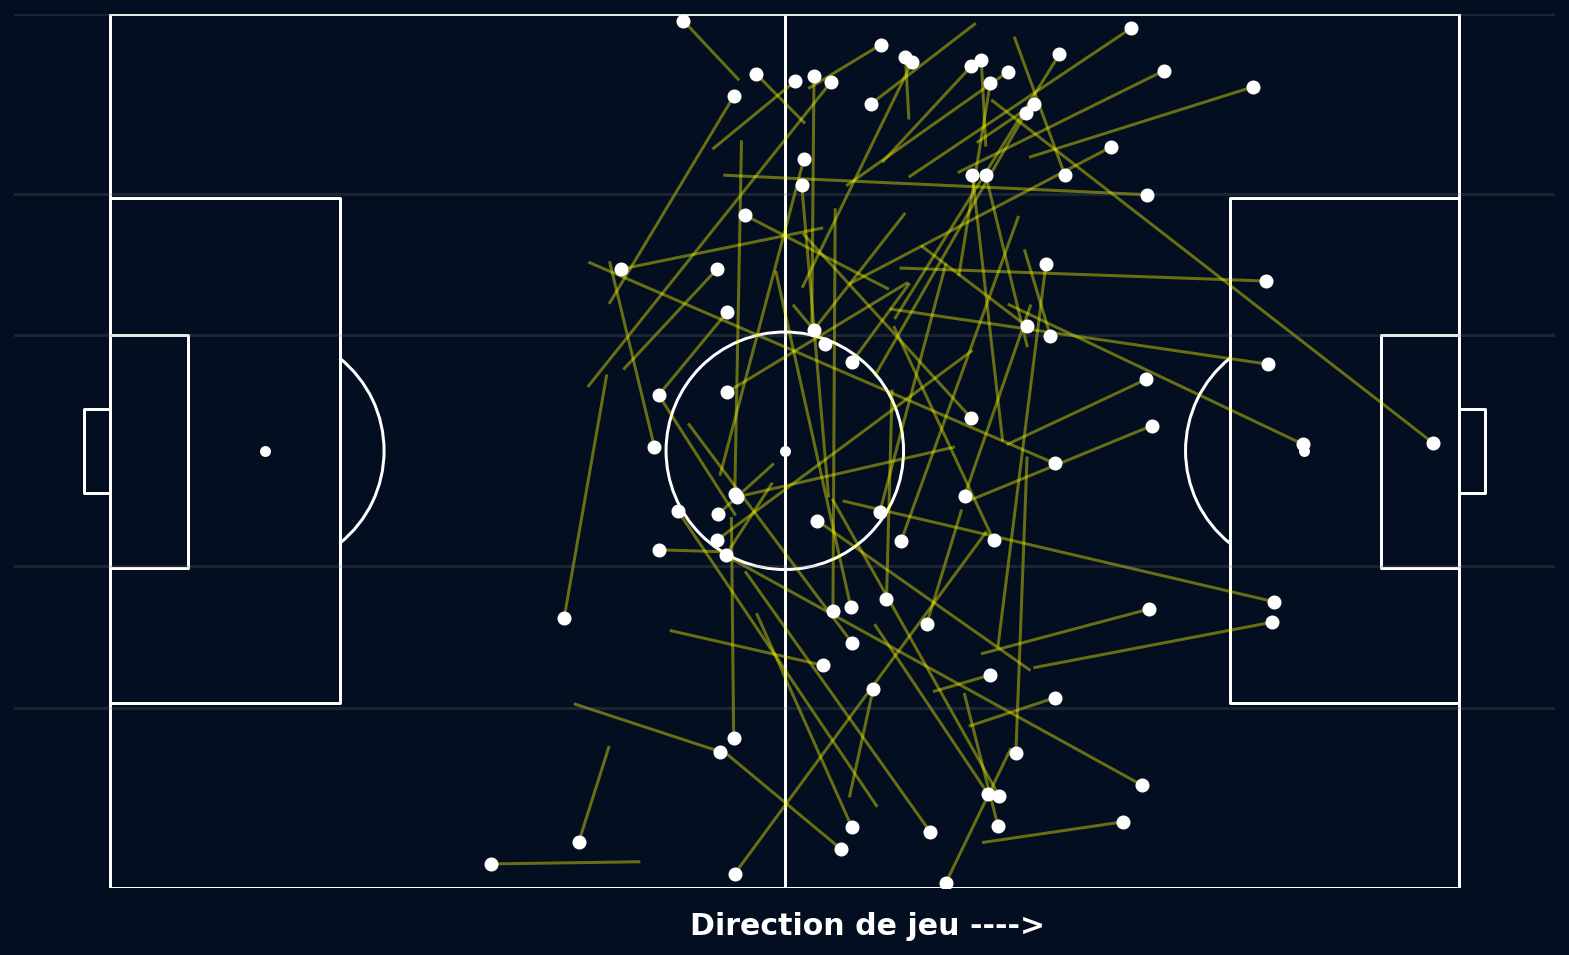

time: 895 ms (started: 2021-08-26 16:19:34 +02:00)


In [127]:
# Where are pass start locations into the final third?

Team='Dinamo Zagreb'
Player='Lovro Majer'
Type='Pass'
Technique='Through Ball'
Pattern='Regular Play'

LM=df3[(df3.x_zone=='Tiers-Médian') &
      (df3.next_x_zone=='Tiers-offensif')
      &(df3.type=='Pass')].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)

TB=LM[(LM['player']==Player)].reset_index(drop=True)

# Visualize through balls from Lovro Majer #
  
background = "#030E21"

# For Horizontal View #
fig, ax = plt.subplots(figsize=(11, 7))

fig.set_facecolor(background)

draw_pitch(orientation="h",
           aspect="full",
           pitch_color=background, 
           line_color="w",
           ax=ax)

x = TB.Start_x.values
y = TB.Start_y.values
xe = TB.End_x.values
ye = TB.End_y.values

plt.scatter(xe,ye,color="w",edgecolors="w",zorder=20,alpha=1)
plt.plot([x,xe],[y,ye],alpha=0.4,color="yellow")



#plt.title("Lovro Majer: Through Passes Start Locations",fontsize=18,color="w",**csfont,fontweight="bold")
fig.text(0.44,0.02,'Direction de jeu ---->',fontweight="bold", fontsize=15,**csfont, color="w") ###change


plt.axhline(y=14,color="grey",alpha=0.2)
plt.axhline(y=25,color="grey",alpha=0.2)
plt.axhline(y=43,color="grey",alpha=0.2)
plt.axhline(y=54,color="grey",alpha=0.2)
plt.axhline(y=68,color="grey",alpha=0.2)

ax.set_ylim(0,68)

plt.tight_layout()
plt.show()

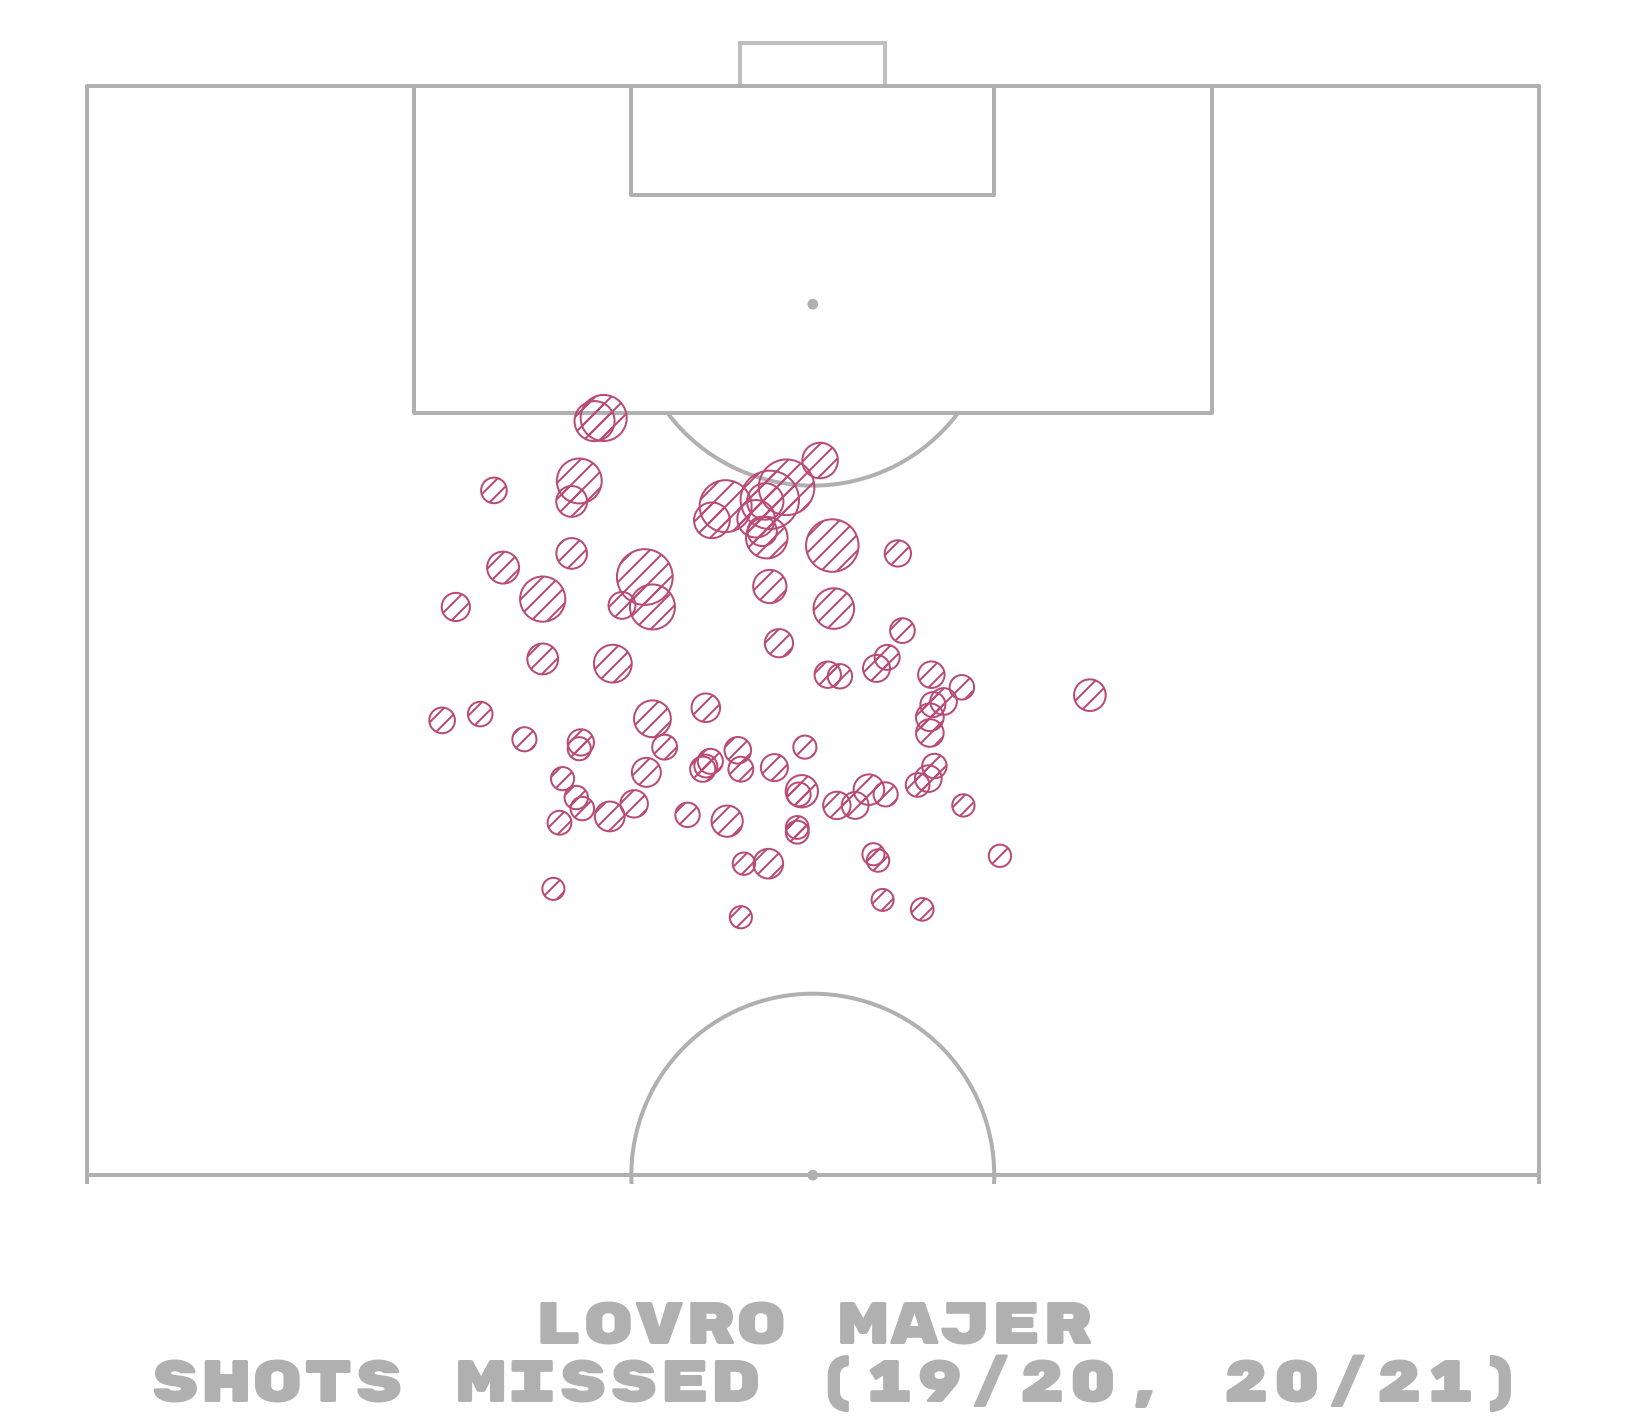

time: 6.64 s (started: 2021-09-06 15:09:42 +02:00)


In [59]:
# Where are the shots coming from?

fm_rubik = FontManager(('https://github.com/google/fonts/blob/main/ofl/rubikmonoone/'
                        'RubikMonoOne-Regular.ttf?raw=true'))

Team='Dinamo Zagreb'
Player='Lovro Majer'
Type='Pass'
Technique='Through Ball'
Pattern='Regular Play'

LM=df3[(df3.type=='Shot') & (df3['player']==Player)].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)

# filter goals / non-shot goals
df_goals = LM[LM.shot_outcome == 'Goal'].copy()
df_non_goal_shots = LM[LM.shot_outcome != 'Goal'].copy()

pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8)  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))

# plot non-goal shots with hatch
sc1 = pitch.scatter(df_non_goal_shots.Start_x, df_non_goal_shots.Start_y,
                    # size varies between 100 and 1900 (points squared)
                    s=(df_non_goal_shots.shot_statsbomb_xg * 1900) + 100,
                    edgecolors='#b94b75',  # give the markers a charcoal border
                    c='None',  # no facecolor for the markers
                    hatch='///',  # the all important hatch (triple diagonal lines)
                    # for other markers types see: https://matplotlib.org/api/markers_api.html
                    marker='o',
                    ax=ax)

txt = ax.text(x=40, y=50, s='Lovro Majer\n Shots Missed (19/20, 20/21)',
              size=30,
              # here i am using a downloaded font from google fonts instead of passing a fontdict
              fontproperties=fm_rubik.prop, color=pitch.line_color,
              va='center', ha='center')

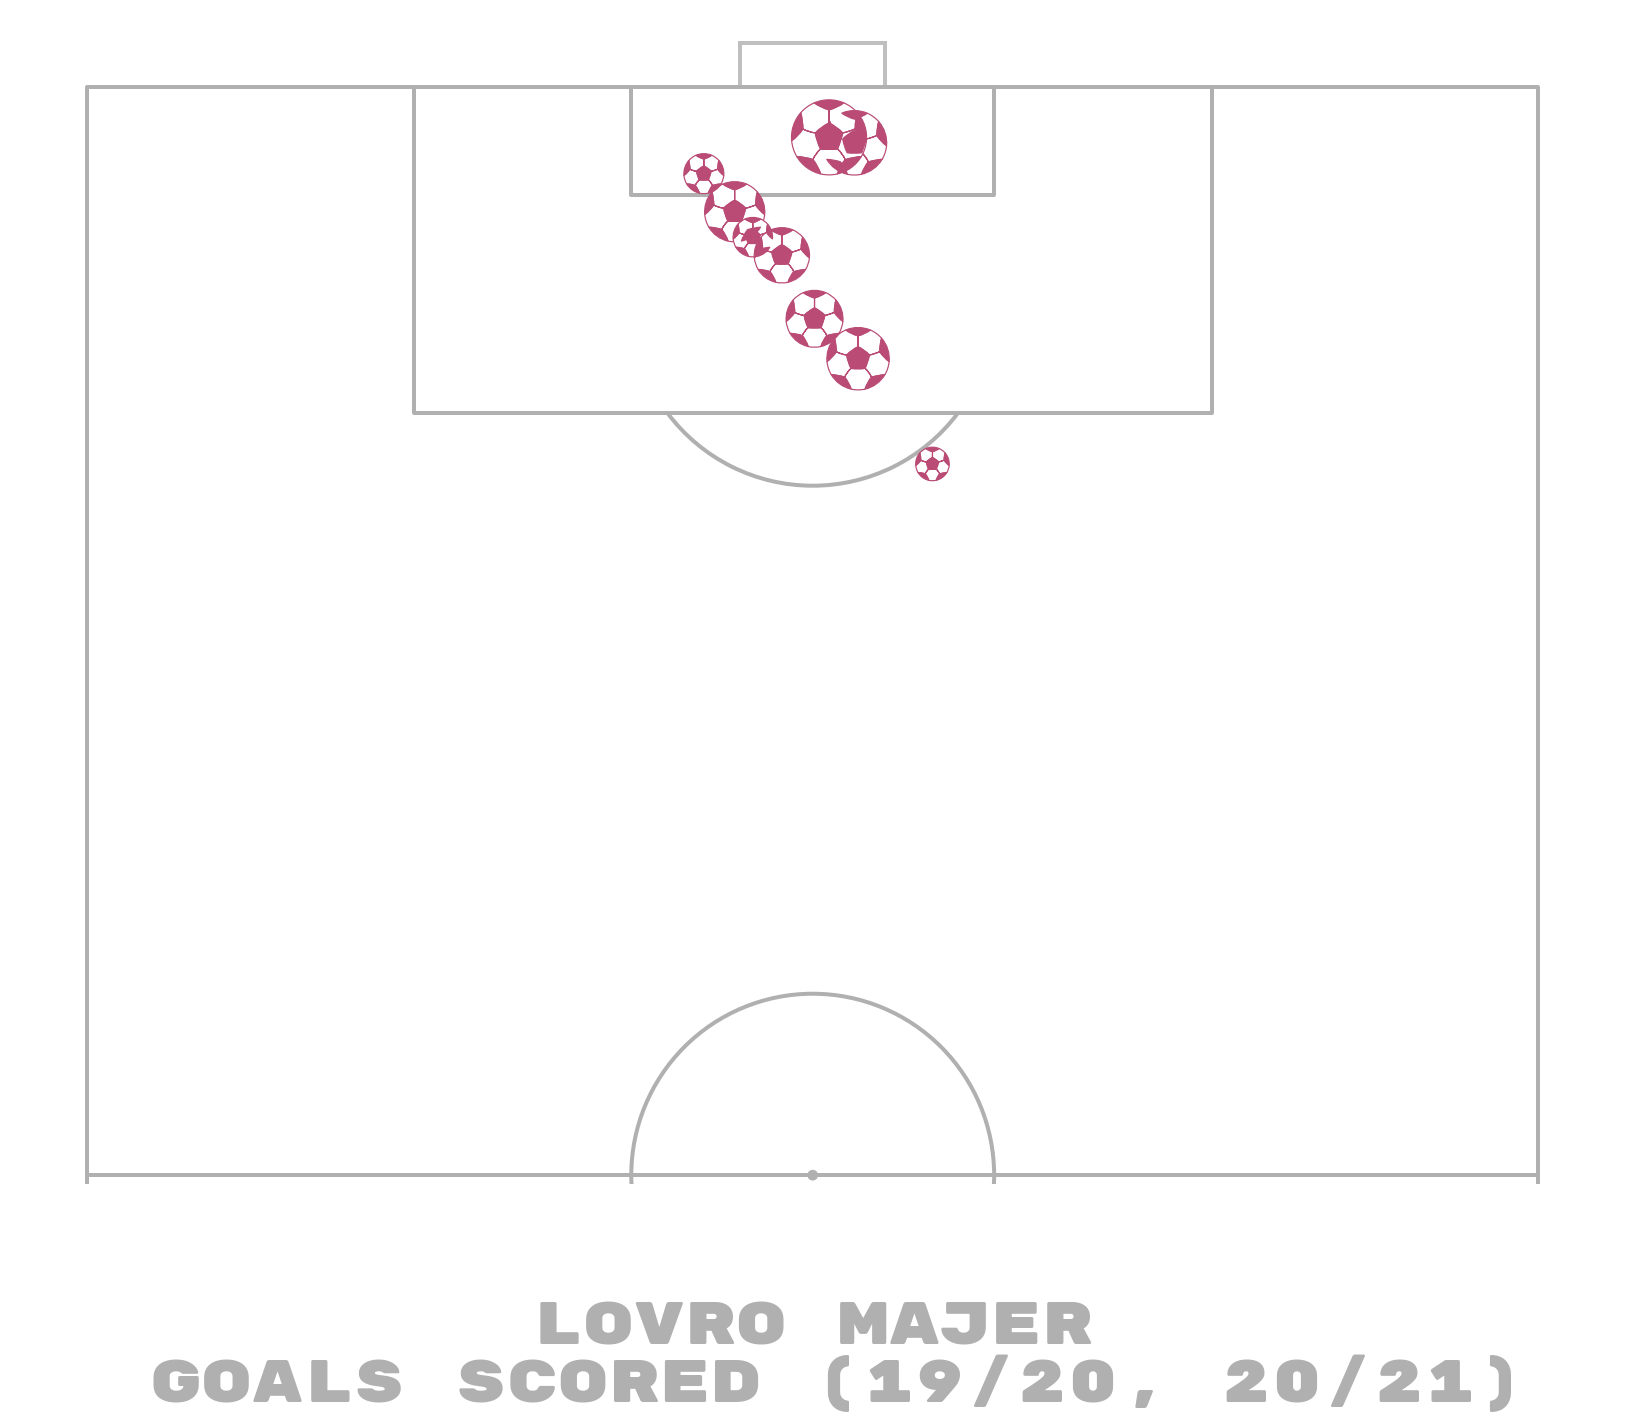

time: 1.01 s (started: 2021-08-30 17:05:26 +02:00)


In [95]:
# Where are the shots coming from?

fm_rubik = FontManager(('https://github.com/google/fonts/blob/main/ofl/rubikmonoone/'
                        'RubikMonoOne-Regular.ttf?raw=true'))

Team='Dinamo Zagreb'
Player='Lovro Majer'
Type='Pass'
Technique='Through Ball'
Pattern='Regular Play'

LM=df3[(df3.type=='Shot') & (df3['player']==Player)].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)

# filter goals / non-shot goals
df_goals = LM[LM.shot_outcome == 'Goal'].copy()

pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8)  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))

# plot non-goal shots with hatch
sc1 = pitch.scatter(df_goals.Start_x, df_goals.Start_y,
                    # size varies between 100 and 1900 (points squared)
                    s=(df_goals.shot_statsbomb_xg * 1900) + 100,
                    edgecolors='#b94b75',
                    linewidth=0.6,
                    c='white',
                    marker='football',
                    ax=ax)

txt = ax.text(x=40, y=50, s='Lovro Majer\n Goals Scored (19/20, 20/21)',
              size=30,
              # here i am using a downloaded font from google fonts instead of passing a fontdict
              fontproperties=fm_rubik.prop, color=pitch.line_color,
              va='center', ha='center')

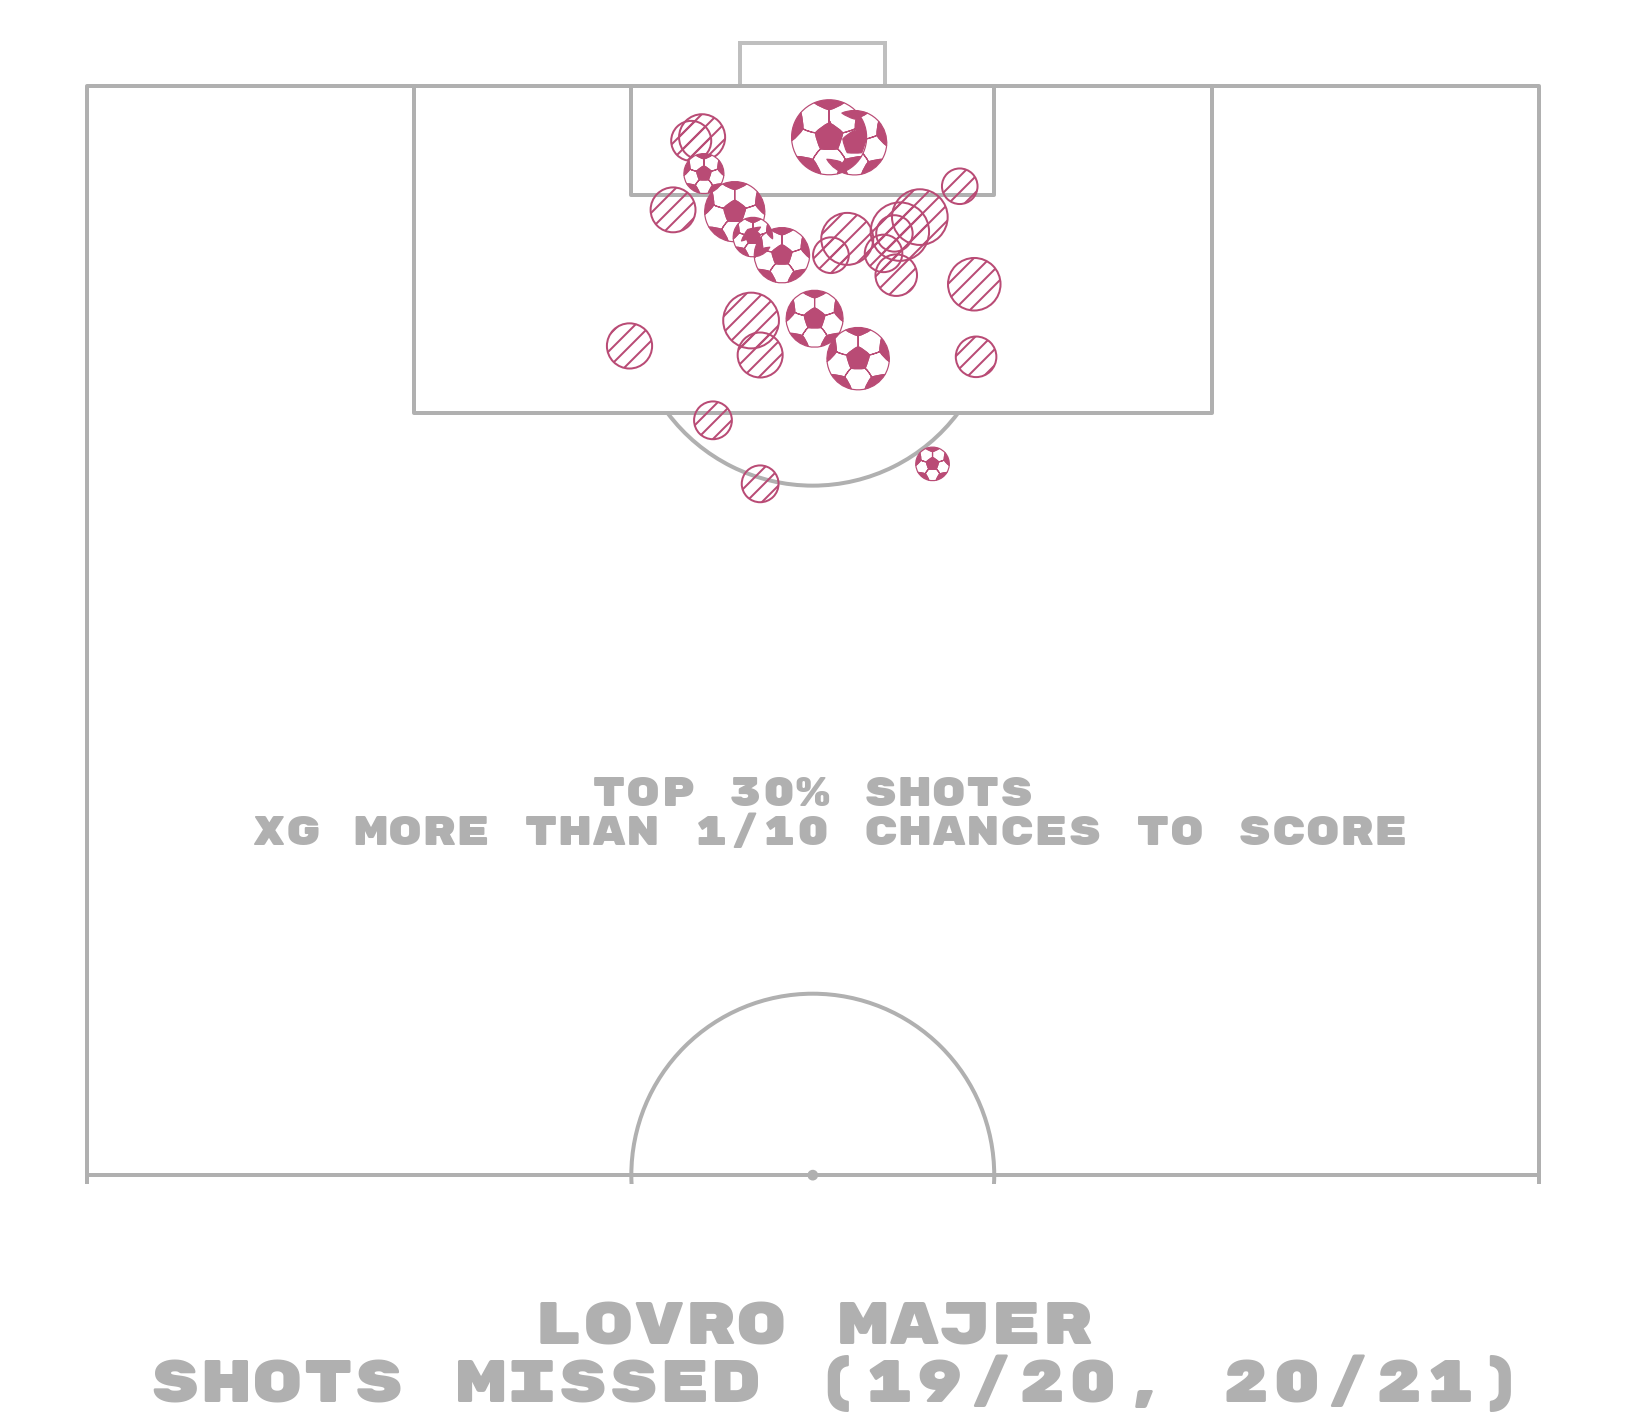

time: 1.44 s (started: 2021-08-30 17:11:40 +02:00)


In [98]:
# Where are the shots coming from?

fm_rubik = FontManager(('https://github.com/google/fonts/blob/main/ofl/rubikmonoone/'
                        'RubikMonoOne-Regular.ttf?raw=true'))

Team='Dinamo Zagreb'
Player='Lovro Majer'
Type='Pass'
Technique='Through Ball'
Pattern='Regular Play'

LM=df2[(df2.type=='Shot') 
       & (df2['player']==Player)].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)

#I want the Goals and the High xG shots
xg_shots=sorted(list(LM.shot_statsbomb_xg.unique()), reverse=True)
xg_shots1= [i for i in xg_shots if i >= 0.1]

LM1=LM[LM['shot_statsbomb_xg'].isin(xg_shots1)].reset_index(drop=True)

# filter goals / non-shot goals
df_goals = LM1[LM1.shot_outcome == 'Goal'].copy()
df_non_goal_shots = LM1[LM1.shot_outcome != 'Goal'].copy()

pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8)  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))

# plot non-goal shots with hatch
sc1 = pitch.scatter(df_non_goal_shots.Start_x, df_non_goal_shots.Start_y,
                    # size varies between 100 and 1900 (points squared)
                    s=(df_non_goal_shots.shot_statsbomb_xg * 1900) + 100,
                    edgecolors='#b94b75',  # give the markers a charcoal border
                    c='None',  # no facecolor for the markers
                    hatch='///',  # the all important hatch (triple diagonal lines)
                    # for other markers types see: https://matplotlib.org/api/markers_api.html
                    marker='o',
                    ax=ax)

txt = ax.text(x=40, y=50, s='Lovro Majer\n Shots Missed (19/20, 20/21)',
              size=30,
              # here i am using a downloaded font from google fonts instead of passing a fontdict
              fontproperties=fm_rubik.prop, color=pitch.line_color,
              va='center', ha='center')

# plot non-goal shots with hatch
sc1 = pitch.scatter(df_goals.Start_x, df_goals.Start_y,
                    # size varies between 100 and 1900 (points squared)
                    s=(df_goals.shot_statsbomb_xg * 1900) + 100,
                    edgecolors='#b94b75',
                    linewidth=0.6,
                    c='white',
                    marker='football',
                    ax=ax)

txt = ax.text(x=40, y=80, s='Top 30% shots\n xG more than 1/10 Chances to score',
              size=20,
              # here i am using a downloaded font from google fonts instead of passing a fontdict
              fontproperties=fm_rubik.prop, color=pitch.line_color,
              va='center', ha='center')

In [99]:
LM1.to_csv('/Users/vignesh.jayanth/Documents/LM1.csv')

time: 6.24 ms (started: 2021-08-30 17:12:12 +02:00)


In [89]:
df.position.unique()

array([nan, 'Left Center Forward', 'Right Center Back', 'Goalkeeper', 'Right Back', 'Left Center Back', 'Left Back',
       'Right Wing Back', 'Left Wing Back', 'Right Defensive Midfield', 'Right Wing', 'Right Center Midfield',
       'Center Defensive Midfield', 'Left Center Midfield', 'Center Back', 'Center Forward', 'Left Wing',
       'Right Center Forward', 'Center Attacking Midfield', 'Left Defensive Midfield', 'Left Attacking Midfield',
       'Right Attacking Midfield', 'Left Midfield', 'Right Midfield', 'Substitute'], dtype=object)

time: 314 ms (started: 2021-08-30 14:57:22 +02:00)


In [70]:
print(len(xg_shots1))
print(len(xg_shots))

27
94
time: 324 µs (started: 2021-08-30 12:29:59 +02:00)


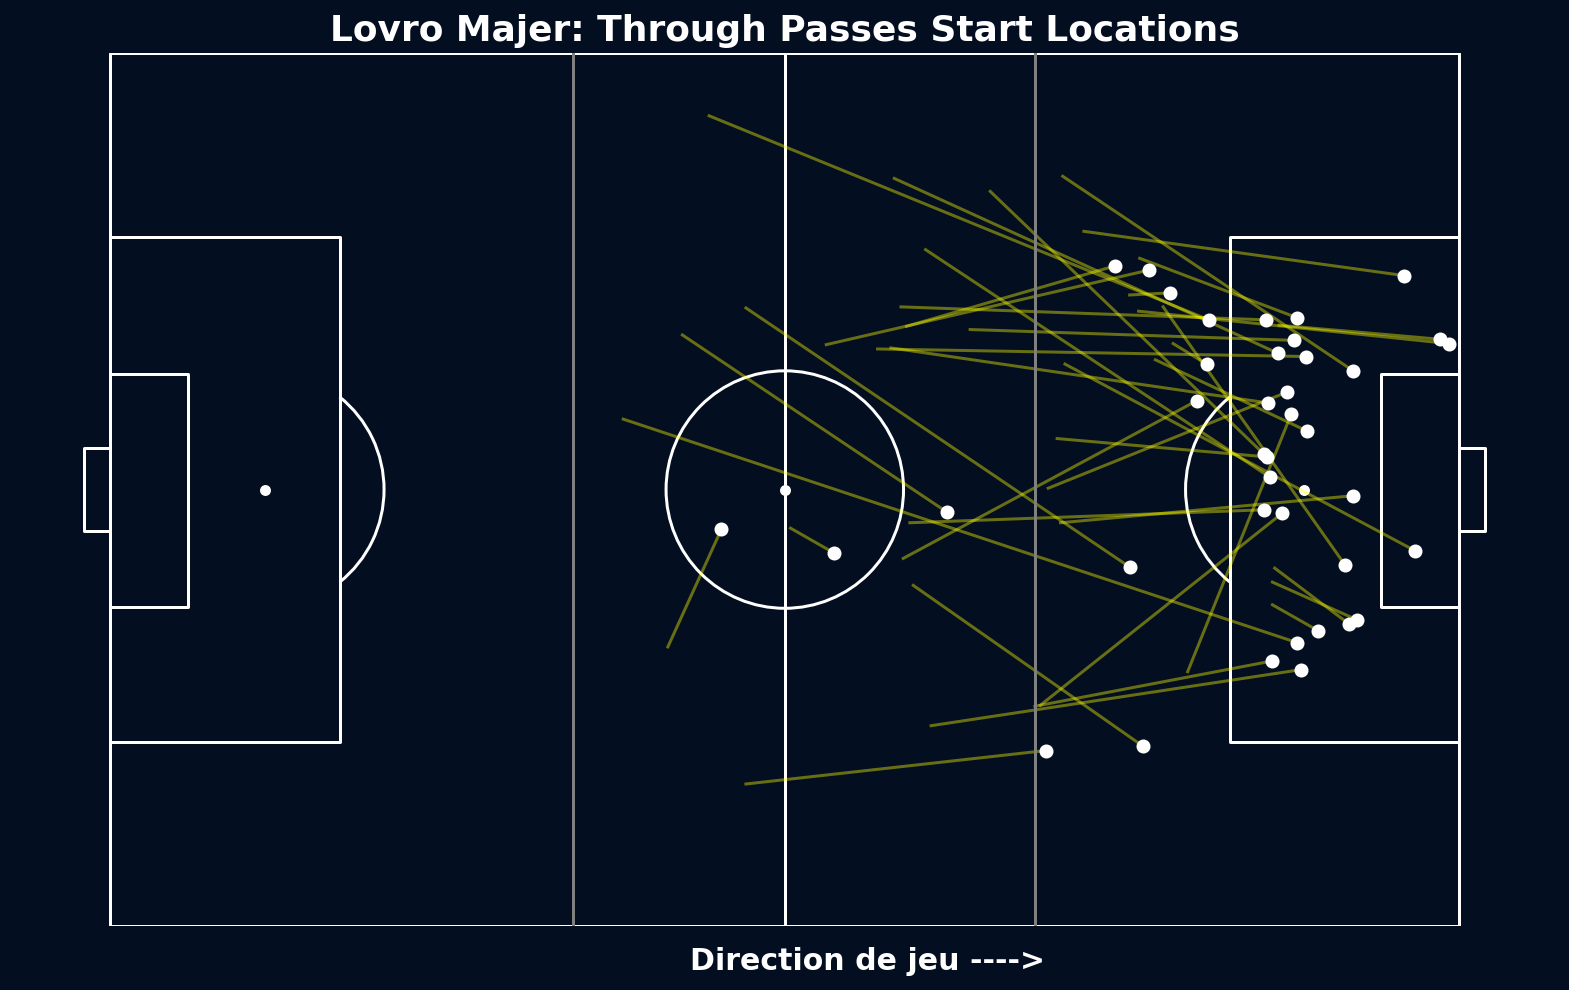

time: 501 ms (started: 2021-09-07 13:54:26 +02:00)


In [30]:
csfont = {'fontfamily':'Montserrat'}

# Where are the through passes coming from Regular Play?

Team='Dinamo Zagreb'
Player='Lovro Majer'
Type='Pass'
Technique='Through Ball'
Pattern='Regular Play'

LM=df3[(df3.player==Player)].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)

TB=LM[(LM['pass_technique']==Technique)].reset_index(drop=True)

# Visualize through balls from Lovro Majer #
Patterns=TB.play_pattern.values
  
background = "#030E21"

# For Horizontal View #
fig, ax = plt.subplots(figsize=(11, 7))

fig.set_facecolor(background)

draw_pitch(orientation="h",
           aspect="full",
           pitch_color=background, 
           line_color="w",
           ax=ax)

x = TB.Start_x.values
y = TB.Start_y.values
xe = TB.End_x.values
ye = TB.End_y.values

plt.scatter(xe,ye,color="w",edgecolors="w",zorder=20,alpha=1)

plt.plot([x,xe],[y,ye],alpha=0.4,color="yellow")

plt.title("Lovro Majer: Through Passes Start Locations",fontsize=18,color="w",**csfont,fontweight="bold")
fig.text(0.44,0.02,'Direction de jeu ---->',fontweight="bold", fontsize=15,**csfont, color="w") ###change

plt.axvline(x=36,color="grey")
plt.axvline(x=72,color="grey")
ax.set_ylim(0,68)

plt.tight_layout()
plt.show()

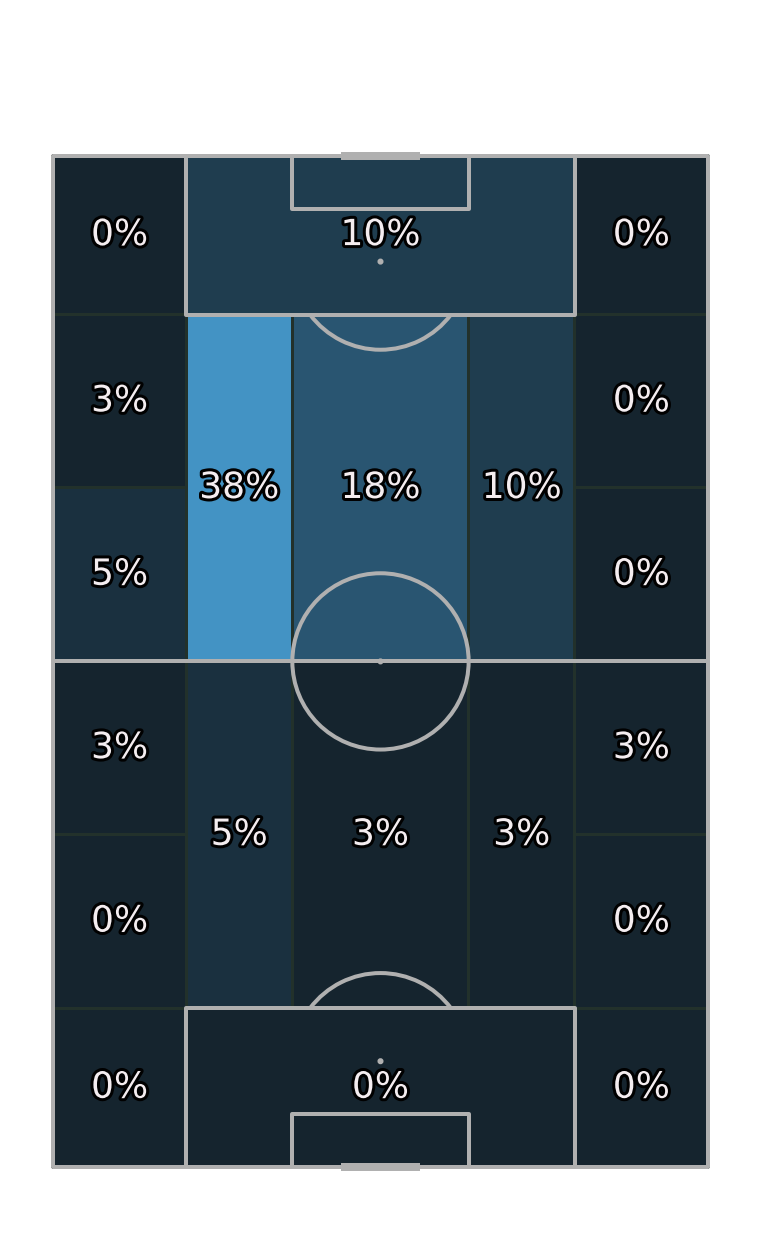

time: 1.17 s (started: 2021-09-07 13:56:59 +02:00)


In [32]:

pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)

# fontmanager for google font (robotto)
robotto_regular = FontManager()

path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]

pitch = VerticalPitch(pitch_type='uefa', line_zorder=2, pitch_color='w')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('w')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(TB.Start_x, TB.Start_y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap=pearl_earring_cmap, edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)


plt.show()  # If you are using a Jupyter notebook you do not need this line

In [44]:
df3.shot_type.unique()

array([nan, 'Open Play', 'Corner', 'Penalty', 'Free Kick', 'Kick Off'], dtype=object)

time: 3.24 s (started: 2021-09-06 11:02:17 +02:00)


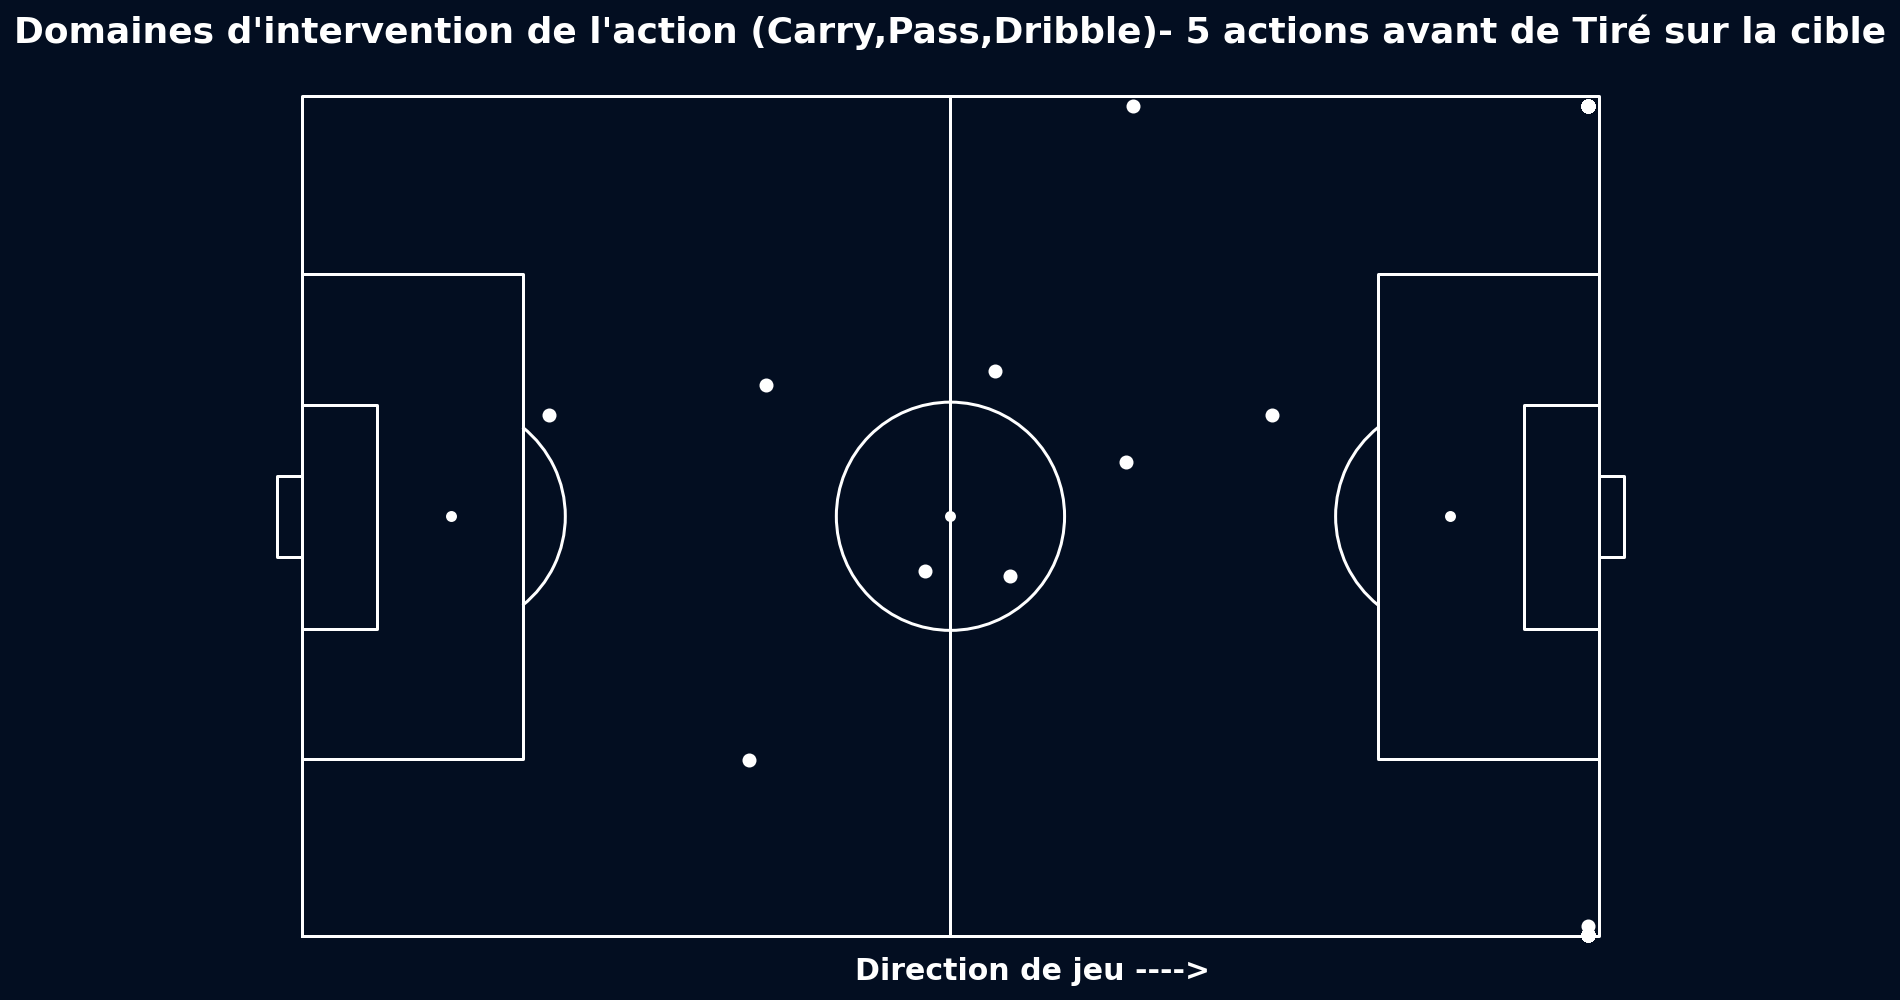

time: 4.39 s (started: 2021-09-07 13:52:54 +02:00)


In [27]:
# Player Involvement areas before a shot on target?

Team='Dinamo Zagreb'
Player='Lovro Majer'
Type='Shot'
Pattern='Regular Play'
Shot_type='Open Play'

ST=df3[(df3.type==Type) & (df3.shot_type==Shot_type)].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)

Actions_involved=['Carry','Pass','Dribble']

ST1=ST[(ST['player-1']==Player) & (ST['prev_event1'].isin(Actions_involved)) & 
      (ST['player-2']!=Player) & (ST['player-3']!=Player) & (ST['player-4']!=Player) & 
      (ST['player-5']!=Player)].reset_index(drop=True)
ST1['Final_x']=ST1['prev_x1']
ST1['Final_y']=ST1['prev_y1']
ST1['Player°']=ST1['player-1']
ST1['prev_event°']=ST1['prev_event1']


ST2=ST[(ST['player-2']==Player) & (ST['prev_event2'].isin(Actions_involved)) & 
      (ST['player-1']!=Player) & (ST['player-3']!=Player) & (ST['player-4']!=Player) & 
      (ST['player-5']!=Player)].reset_index(drop=True)
ST2['Final_x']=ST2['prev_x2']
ST2['Final_y']=ST2['prev_y2']
ST2['Player°']=ST2['player-2']
ST2['prev_event°']=ST2['prev_event2']


ST3=ST[(ST['player-3']==Player) & (ST['prev_event3'].isin(Actions_involved)) & 
      (ST['player-2']!=Player) & (ST['player-1']!=Player) & (ST['player-4']!=Player) & 
      (ST['player-5']!=Player)].reset_index(drop=True)
ST3['Final_x']=ST3['prev_x3']
ST3['Final_y']=ST3['prev_y3']
ST3['Player°']=ST3['player-3']
ST3['prev_event°']=ST3['prev_event3']


ST4=ST[(ST['player-4']==Player) & (ST['prev_event4'].isin(Actions_involved)) & 
      (ST['player-2']!=Player) & (ST['player-3']!=Player) & (ST['player-1']!=Player) & 
      (ST['player-5']!=Player)].reset_index(drop=True)
ST4['Final_x']=ST4['prev_x4']
ST4['Final_y']=ST4['prev_y4']
ST4['Player°']=ST4['player-4']
ST4['prev_event°']=ST4['prev_event4']


ST5=ST[(ST['player-5']==Player) & (ST['prev_event5'].isin(Actions_involved)) & 
      (ST['player-2']!=Player) & (ST['player-3']!=Player) & (ST['player-4']!=Player) & 
      (ST['player-1']!=Player)].reset_index(drop=True)
ST5['Final_x']=ST5['prev_x5']
ST5['Final_y']=ST5['prev_y5']
ST5['Player°']=ST5['player-5']
ST5['prev_event°']=ST5['prev_event5']

ST_final=pd.concat([ST1,ST2,ST3,ST4,ST5])


# Identifying the Previous "5 players involved in actions"

background = "#030E21"

# For Horizontal View #
fig, ax = plt.subplots(figsize=(11, 7))

fig.set_facecolor(background)

draw_pitch(orientation="h",
           aspect="full",
           pitch_color=background, 
           line_color="w",
           ax=ax)

x = ST_final.Final_x.values
y = ST_final.Final_y.values
Player = ST_final['Player°'].values


plt.scatter(x,y,color="w",edgecolors="w",zorder=12,alpha=1)

plt.title("Domaines d'intervention de l'action (Carry,Pass,Dribble)- 5 actions avant de Tiré sur la cible",fontsize=18,color="w",fontweight="bold")
fig.text(0.44,0.02,'Direction de jeu ---->',fontweight="bold", fontsize=15, color="w") ###change


plt.tight_layout()
plt.show()

In [25]:
ST_final1=ST_final[['minute','second','shot_body_part','timestamp','player',
                    'match_date','home_team_name','away_team_name']]
ST_final1.to_excel('/Users/vignesh.jayanth/Documents/ST_final.xlsx')

time: 26.5 ms (started: 2021-09-07 12:19:34 +02:00)


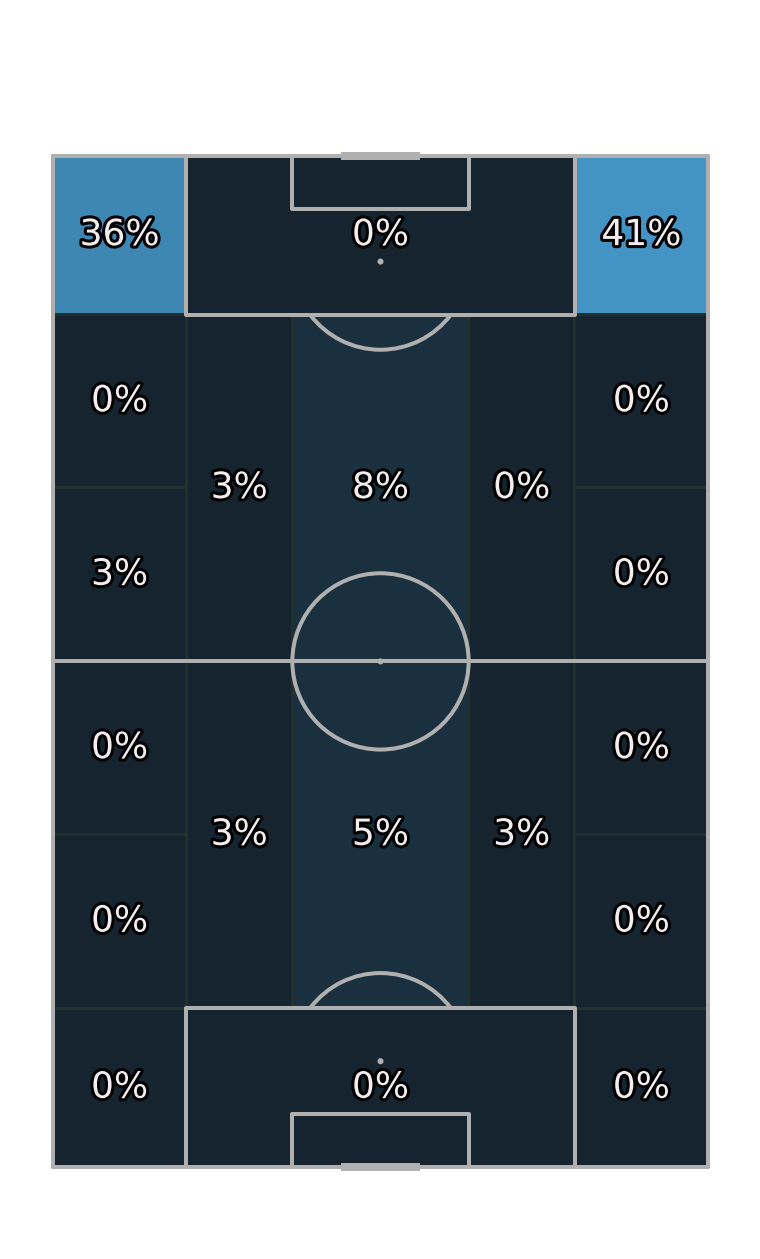

time: 558 ms (started: 2021-09-07 12:12:22 +02:00)


In [24]:

pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)

# fontmanager for google font (robotto)
robotto_regular = FontManager()

path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]

pitch = VerticalPitch(pitch_type='uefa', line_zorder=2, pitch_color='w')
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0,
                      title_height=0.08, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.84)
fig.set_facecolor('w')

# heatmap and labels
bin_statistic = pitch.bin_statistic_positional(ST_final.Final_x, ST_final.Final_y, statistic='count',
                                               positional='full', normalize=True)
pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                         cmap=pearl_earring_cmap, edgecolors='#22312b')
labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', path_effects=path_eff)


plt.show()  # If you are using a Jupyter notebook you do not need this line

In [58]:
TB_df=pd.DataFrame(ST_final.groupby(['season_name','prev_event°']).size() / len(TB)*100)
TB_df=TB_df.set_axis(['Percentage'], axis=1, inplace=False)
TB_df.reset_index(level=['season_name','prev_event°'],inplace=True)
TB_df.to_excel('/Users/vignesh.jayanth/Documents/Lovro Majer/F_cmp.xlsx')

time: 15.4 ms (started: 2021-09-06 11:12:35 +02:00)


In [ ]:



pitch = VerticalPitch(line_color='#000009', line_zorder=2)
fig, ax = pitch.draw(figsize=(4.4, 6.4))
kde = pitch.kdeplot(df.Start_x, df.Start_y, ax=ax,
                    # shade using 100 levels so it looks smooth
                    shade=True, levels=100,
                    # shade the lowest area so it looks smooth
                    # so even if there are no events it gets some color
                    shade_lowest=True,
                    cut=4,  # extended the cut so it reaches the bottom edge
                    cmap='Blues')

In [159]:
print(len(ST))

2956
time: 369 µs (started: 2021-08-26 17:55:38 +02:00)


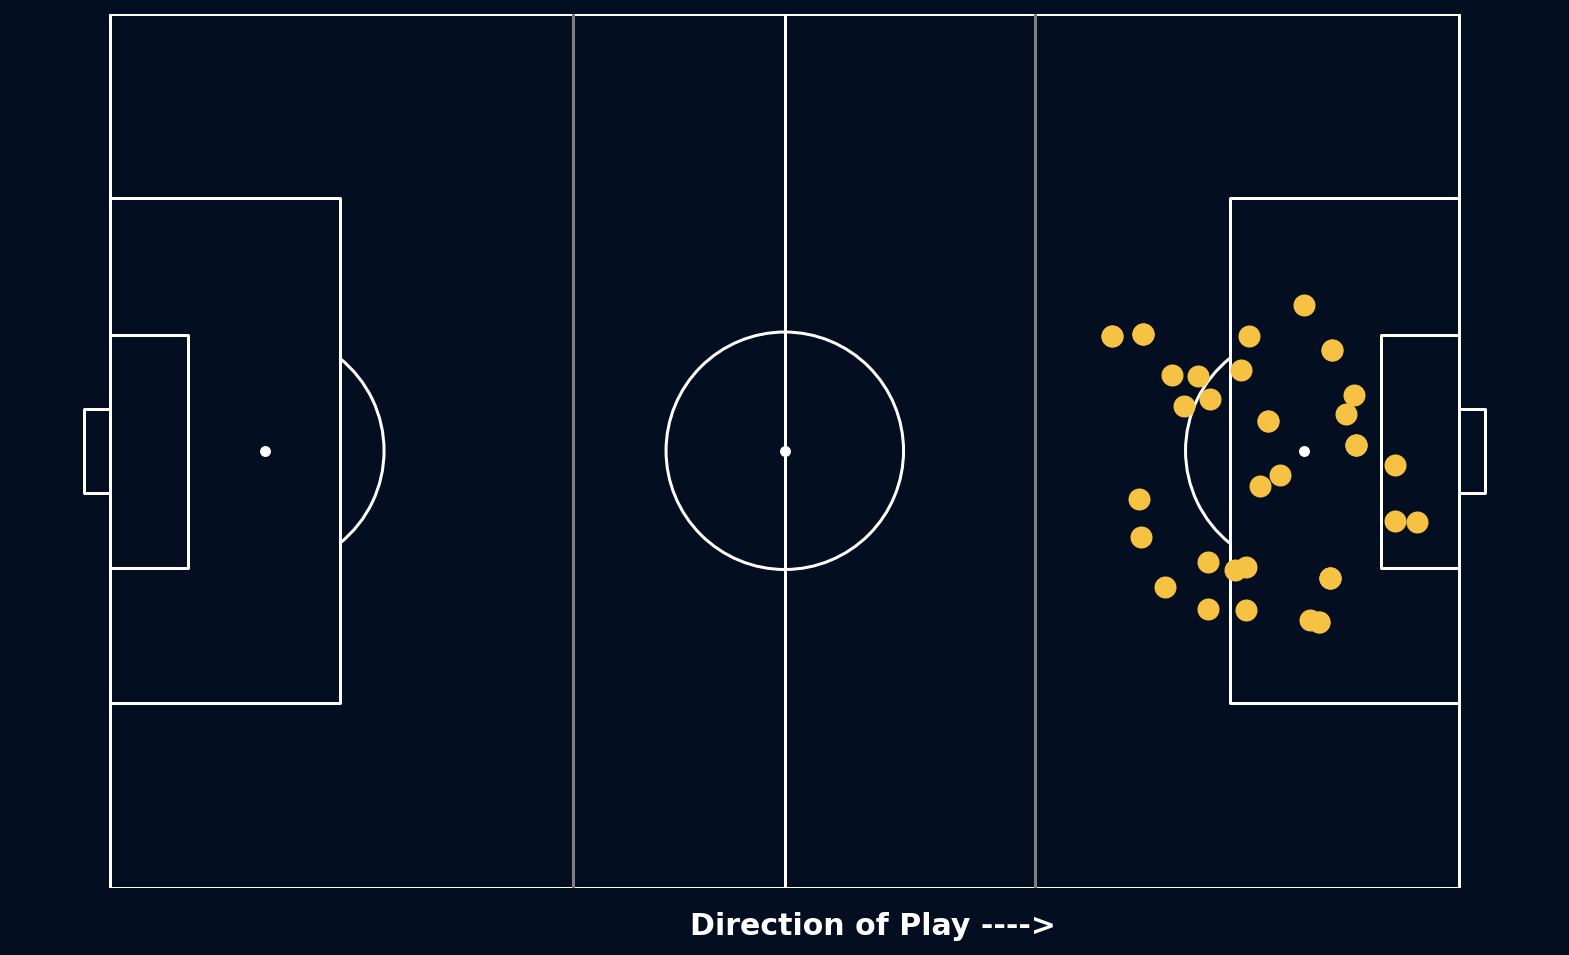

time: 604 ms (started: 2021-08-25 10:22:20 +02:00)


In [66]:
# Player Involvement areas before a shot on target?

Team='Dinamo Zagreb'
Player='Lovro Majer'
Type='Shot'
Pattern='Regular Play'

ST=df3[(df3.play_pattern==Pattern) &
      (df3.type==Type)].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)

Actions_involved=['Ball Receipt*', 'Carry', 'Duel','Pass']

ST1=ST[(ST['player_1']==Player) & (ST['prev_1'].isin(Actions_involved))].reset_index(drop=True)
ST2=ST[(ST['player_2']==Player) & (ST['prev_2'].isin(Actions_involved))].reset_index(drop=True)
ST3=ST[(ST['player_3']==Player) & (ST['prev_3'].isin(Actions_involved))].reset_index(drop=True)
ST4=ST[(ST['player_4']==Player) & (ST['prev_4'].isin(Actions_involved))].reset_index(drop=True)
ST5=ST[(ST['player_5']==Player) & (ST['prev_5'].isin(Actions_involved))].reset_index(drop=True)


ST_final=pd.concat([ST1,ST2,ST3,ST4,ST5])

# Identifying the Previous "5 players involved in actions"

background = "#030E21"

# For Horizontal View #
fig, ax = plt.subplots(figsize=(11, 7))

fig.set_facecolor(background)

draw_pitch(orientation="h",
           aspect="full",
           pitch_color=background, 
           line_color="w",
           ax=ax)

x = ST_final.Start_x.values
y = ST_final.Start_y.values
xe = ST_final.End_x.values
ye = ST_final.End_y.values

plt.scatter(x,y,color="#F6C244",edgecolors="#F6C244",zorder=12,alpha=1,s=100)

plt
#plt.title("Action Involvement Areas (Open Play)- 5 Actions before Shot on Target",fontsize=18,color="w",**csfont,fontweight="bold")
fig.text(0.44,0.02,'Direction de jeu ---->',fontweight="bold", fontsize=15,**csfont, color="w") ###change

plt.axvline(x=36,color="grey")
plt.axvline(x=72,color="grey")
ax.set_ylim(0,68)

plt.tight_layout()
plt.show()

In [ ]:
# Free Kick Locations?

Team='Dinamo Zagreb'
Player='Lovro Majer'
Type='Shot'
Pattern='Regular Play'

ST=df3[(df3.play_pattern==Pattern) &
      (df3.type==Type)].sort_values(by=['match_id','index'], ascending=True).reset_index(drop=True)

Actions_involved=['Ball Receipt*', 'Carry', 'Duel','Pass']

ST1=ST[(ST['player_1']==Player) & (ST['prev_1'].isin(Actions_involved))].reset_index(drop=True)
ST2=ST[(ST['player_2']==Player) & (ST['prev_2'].isin(Actions_involved))].reset_index(drop=True)
ST3=ST[(ST['player_3']==Player) & (ST['prev_3'].isin(Actions_involved))].reset_index(drop=True)
ST4=ST[(ST['player_4']==Player) & (ST['prev_4'].isin(Actions_involved))].reset_index(drop=True)
ST5=ST[(ST['player_5']==Player) & (ST['prev_5'].isin(Actions_involved))].reset_index(drop=True)


ST_final=pd.concat([ST1,ST2,ST3,ST4,ST5])

# Identifying the Previous "5 players involved in actions"

background = "#030E21"

# For Horizontal View #
fig, ax = plt.subplots(figsize=(11, 7))

fig.set_facecolor(background)

draw_pitch(orientation="h",
           aspect="full",
           pitch_color=background, 
           line_color="w",
           ax=ax)

x = ST_final.Start_x.values
y = ST_final.Start_y.values
xe = ST_final.End_x.values
ye = ST_final.End_y.values

plt.scatter(xe,ye,color="w",edgecolors="w",zorder=12,alpha=1)

plt.plot([x,xe],[y,ye],alpha=0.4,color="yellow")

plt.title("Action Involvement Areas (Open Play)- 5 Actions before Shot on Target",fontsize=18,color="w",**csfont,fontweight="bold")
fig.text(0.44,0.02,'Direction de jeu ---->',fontweight="bold", fontsize=15,**csfont, color="w") ###change


plt.tight_layout()
plt.show()

In [31]:
ST1

bad_behaviour_card ball_receipt_outcome ball_recovery_offensive  \
0                NaN                  NaN                     NaN   
1                NaN                  NaN                     NaN   
2                NaN                  NaN                     NaN   
3                NaN                  NaN                     NaN   
4                NaN                  NaN                     NaN   
5                NaN                  NaN                     NaN   
6                NaN                  NaN                     NaN   
7                NaN                  NaN                     NaN   

  ball_recovery_recovery_failure block_deflection block_offensive  \
0                            NaN              NaN             NaN   
1                            NaN              NaN             NaN   
2                            NaN              NaN             NaN   
3                            NaN              NaN             NaN   
4                            NaN              NaN             NaN   
5                            NaN              NaN             NaN   
6                            NaN              NaN             NaN   
7                            NaN              NaN             NaN   

  block_save_block clearance_aerial_won clearance_body_part clearance_head  \
0              NaN                  NaN                 NaN            NaN   
1              NaN                  NaN                 NaN            NaN   
2              NaN                  NaN                 NaN            NaN   
3              NaN                  NaN                 NaN            NaN   
4              NaN                  NaN                 NaN            NaN   
5              NaN                  NaN                 NaN            NaN   
6              NaN                  NaN                 NaN            NaN   
7              NaN                  NaN                 NaN            NaN   

  clearance_left_foot clearance_other clearance_right_foot counterpress  \
0                 NaN             NaN                  NaN          NaN   
1                 NaN             NaN                  NaN          NaN   
2                 NaN             NaN                  NaN          NaN   
3                 NaN             NaN                  NaN          NaN   
4                 NaN             NaN                  NaN          NaN   
5                 NaN             NaN                  NaN          NaN   
6                 NaN             NaN                  NaN          NaN   
7                 NaN             NaN                  NaN          NaN   

  dribble_no_touch dribble_nutmeg dribble_outcome dribble_overrun  \
0              NaN            NaN             NaN             NaN   
1              NaN            NaN             NaN             NaN   
2              NaN            NaN             NaN             NaN   
3              NaN            NaN             NaN             NaN   
4              NaN            NaN             NaN             NaN   
5              NaN            NaN             NaN             NaN   
6              NaN            NaN             NaN             NaN   
7              NaN            NaN             NaN             NaN   

  duel_outcome duel_type  duration foul_committed_advantage  \
0          NaN       NaN  0.429743                      NaN   
1          NaN       NaN  0.848301                      NaN   
2          NaN       NaN  0.866873                      NaN   
3          NaN       NaN  0.930756                      NaN   
4          NaN       NaN  0.851806                      NaN   
5          NaN       NaN  0.819456                      NaN   
6          NaN       NaN  0.744712                      NaN   
7          NaN       NaN  0.983128                      NaN   

  foul_committed_card foul_committed_offensive foul_committed_penalty  ...  \
0                 NaN                      NaN                    NaN  ...   
1                 NaN            

time: 45.7 ms (started: 2021-08-25 09:39:54 +02:00)


In [33]:
ST_final.prev_1.unique()

array(['Block', 'Ball Receipt*', 'Carry', 'Duel', 'Dispossessed', 'Goal Keeper', 'Pass'], dtype=object)

time: 2.55 ms (started: 2021-08-25 09:43:42 +02:00)


In [ ]:
# Where are the passes into the box or final third coming from ?




In [13]:
LM.pass_technique.unique()

array([nan, 'Through Ball', 'Outswinging', 'Inswinging', 'Straight'], dtype=object)

time: 5.09 ms (started: 2021-08-24 12:30:00 +02:00)


In [ ]:
LM.type.unique()

In [ ]:
## Subset data for all Lovro Majer's games ##

# What is his involvement leading to a shot on target

Team='Dinamo Zagreb'
Player='Lovro Majer'

TM=df3[(df3.team==Team)].sort_values(by='index', ascending=True).reset_index(drop=True)

# Identify where the pass is coming from one action before the shot

SHT1=TM[(TM['type']=='Shot')&
       (TM['player_1']==Player)].reset_index(drop=True)

print({'Percentage': SHT1.groupby(['x_zone', 'y_zone']).size() / len(SHT1)*100})


In [ ]:
# Identify where the pass is coming from two actions before the shot

SHT3=TM[(TM['type']=='Shot')&
       (TM['player_3']==Player)].reset_index(drop=True)

print({'Percentage': SHT3.groupby(['x_zone', 'y_zone','prev_2']).size() / len(SHT3)*100})


In [ ]:
LM['type'].unique()



## What percentage of actions signify valued areas and from where?

## Percentage of ball receipts that led to break through (key pass, shot on goal, 
## or cross into the box) within next three actions or 5 actions

## Which areas can he create most value from?

### What type of passes lead to shots on target? 

In [ ]:
SHT=LM[LM['type']=='Shot'].reset_index(drop=True)

print({'Percentage': SHT.groupby(['prev_1']).size() / len(SHT)*100})


In [ ]:
# Where is he dispossessed the most?

DP=LM[LM['type']=='Dispossessed'].reset_index(drop=True)
print({'Percentage': DP.groupby(['x_zone', 'y_zone']).size() / len(DP)*100})


In [ ]:
# Where does he carry the most?

CR=LM[LM['type']=='Carry'].reset_index(drop=True)
print({'Percentage': CR.groupby(['x_zone', 'y_zone']).size() / len(CR)*100})

In [ ]:
# Where does he dribble the most?

DR=LM[LM['type']=='Dribble'].reset_index(drop=True)
print({'Percentage': DR.groupby(['x_zone', 'y_zone']).size() / len(DR)*100})

In [ ]:
# Which horizontal corridor on the pitch has maximum ball_receipts?

## Check for Ball Receipt Locations ##

BR=LM[LM['type']=='Ball Receipt*'].reset_index(drop=True)

print({'Percentage': BR.groupby(['x_zone', 'y_zone']).size() / len(BR)*100})

# Answer: 

# 1) Middle-Third - Middle: 31%
# 2) Middle-Third - Right: 17%
# 3) Middle-Third - Left-Half-Space: 12.2 %
# 4) Middle-Third - Right-Half-Space: 12%

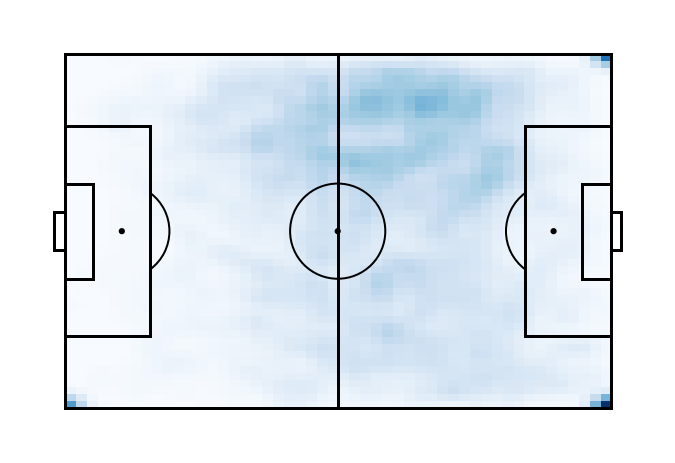

<AxesSubplot:>

time: 136 ms (started: 2021-08-25 10:10:54 +02:00)


In [53]:
# Ball Receipt- heatmap

import matplotsoccer

x=LM['Start_x']
y=LM['Start_y']
hm = matplotsoccer.count(x,y,n=25,m=25) # Construct a 25x25 heatmap from x,y-coordinates
hm = scipy.ndimage.gaussian_filter(hm,1) # blur the heatmap
matplotsoccer.heatmap(hm) # plot the heatmap

In [128]:
# Identifying the Previous "5 players involved in actions"

background = "#030E21"

# For Horizontal View #
fig, ax = plt.subplots(figsize=(11, 7))

fig.set_facecolor(background)

draw_pitch(orientation="h",
           aspect="full",
           pitch_color=background, 
           line_color="w",
           ax=ax)

x = ST_final.Final_x.values
y = ST_final.Final_y.values
Player = ST_final['Player°'].values


plt.scatter(x,y,color="w",edgecolors="w",zorder=12,alpha=1)

plt.title("Domaines d'intervention de l'action (Carry,Pass,Dribble)- 5 actions avant de Tiré sur la cible",fontsize=18,color="w",fontweight="bold")
fig.text(0.44,0.02,'Direction de jeu ---->',fontweight="bold", fontsize=15, color="w") ###change


plt.tight_layout()
plt.show()

time: 190 ms (started: 2021-08-26 16:20:23 +02:00)


In [ ]:
check=df2[df2.team=='Dinamo Zagreb'].reset_index(drop=True)
match_ids=check.match_id.unique()

In [ ]:
for i, txt in enumerate(xe):

     ## Standard move right option value

    t1= [ax.annotate(txt, (xe[i], ye[i]),xytext=(xe[i], ye[i]),color='white', size=10,zorder=5,
                            bbox=dict(facecolor='black', edgecolor='black', pad=1))]